<div align="center">
 <img src="http://www.di.uoa.gr/themes/corporate_lite/logo_en.png" title="Department of Informatics and Telecommunications - University of Athens" align="center" /> 
</div>

<br>

---

<div align="center"> 
  <font size="4"><b>Bachelor Thesis</b> </font>
</div>
<br>
<div align="center"> 
  <font size="5">
      <b>Entity Resolution in Dissimilarity Spaces  <br></b> 
    </font>
     <br>
     <font size="3">
        Implementation notebook     
    </font>
</div>

---

<div align="center"> 
    <font size="4">
         <b>Konstantinos Nikoletos, BS Student</b>
     </font>
</div>
<br>
<div align="center"> 
    <font size="4">
     <b> Dr. Alex Delis</b>,  Professor NKUA <br> 
     <b> Dr. Vassilis Verikios</b>, Professor Hellenic Open University
    </font>
</div>
<br>
<div align="center"> 
    <font size="2">Athens</font>
</div>
<div align="center"> 
    <font size="2">January 2021 - Ongoing</font>
</div>


---

# __Implementation__

## __Install components__

In [9]:
!pip install editdistance
!pip install pandas_read_xml
!pip install requests
!pip install python-igraph

  Using cached urllib3-1.26.7-py2.py3-none-any.whl (138 kB)
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.25.11
    Uninstalling urllib3-1.25.11:
      Successfully uninstalled urllib3-1.25.11


ERROR: conda 4.10.3 requires ruamel_yaml_conda>=0.11.14, which is not installed.
ERROR: requests 2.22.0 has requirement urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you'll have urllib3 1.26.7 which is incompatible.
ERROR: botocore 1.12.189 has requirement urllib3<1.26,>=1.20, but you'll have urllib3 1.26.7 which is incompatible.


  Using cached urllib3-1.25.11-py2.py3-none-any.whl (127 kB)
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.7
    Uninstalling urllib3-1.26.7:
      Successfully uninstalled urllib3-1.26.7


ERROR: conda 4.10.3 requires ruamel_yaml_conda>=0.11.14, which is not installed.
ERROR: pandas-read-xml 0.3.1 has requirement urllib3>=1.26.3, but you'll have urllib3 1.25.11 which is incompatible.


## __Import libraries__

In [10]:
import pandas as pd
import numpy as np
import collections
import editdistance
import string
import sklearn
import pandas_read_xml as pdx
import time
import warnings
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import math
import os
import scipy.special as special
import igraph
import networkx as nx

from tqdm.notebook import tqdm as tqdm
from scipy.spatial.distance import directed_hausdorff,hamming
from scipy.stats._stats import _kendall_dis
from scipy.stats import spearmanr,kendalltau,pearsonr,kruskal,mannwhitneyu
from sklearn.metrics.pairwise import cosine_similarity
from nltk.metrics.distance import jaro_similarity,jaro_winkler_similarity,jaccard_distance
from sklearn.metrics import jaccard_score,accuracy_score,auc,f1_score,recall_score,precision_score,classification_report
from scipy.sparse import csr_matrix
from scipy import sparse
from scipy import stats 
from scipy.spatial.distance import euclidean,hamming,jaccard
from matplotlib.patches import Rectangle
from sklearn.metrics import ndcg_score
from datetime import datetime
from sklearn.decomposition import PCA 
from numpy.linalg import svd

plt.style.use('seaborn-white') # plot style


## __Model__

In [11]:
class RankedWTAHash:

    def __init__(self, max_numberOf_clusters, max_dissimilarityDistance, windowSize, 
                 number_of_permutations=1, min_numOfNodes = 2, jaccard_withchars =True,
                 distanceMetricEmbedding = 'euclidean', metric = 'kendal', similarityVectors='ranked', 
                 distanceMetric = 'edit', prototypesFilterThr=None, ngramms=3, 
                 similarityThreshold=None, maxOnly=None,earlyStop=0):
        '''
          Constructor
        '''
        self.max_numberOf_clusters = max_numberOf_clusters
        self.pairDictionary = dict()
        self.max_dissimilarityDistance = max_dissimilarityDistance
        self.windowSize = windowSize
        self.S_set = None
        self.S_index = None
        self.similarityThreshold = similarityThreshold
        self.maxOnly = maxOnly
        self.metric = metric
        self.min_numOfNodes = min_numOfNodes
        self.similarityVectors = similarityVectors
        self.number_of_permutations = number_of_permutations
        self.distanceMetric = distanceMetric
        self.distanceMetricEmbedding = distanceMetricEmbedding
        self.ngramms = ngramms
        self.jaccard_withchars =  jaccard_withchars
        self.prototypesFilterThr = prototypesFilterThr
        self.earlyStop = earlyStop
        self.selectionVariance = None
        self.numOfComparisons = 0

    def fit(self, X):
        """
          Fit the classifier from the training dataset.
          Parameters
          ----------
          X : Training data.
          
          Returns
          -------
          self : The fitted classifier.
        """
        print("\n#####################################################################\n#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #\n#####################################################################\n")

        if isinstance(X, list):
            input_strings = X
        else:
            input_strings = list(X)

        self.initialS_set = np.array(input_strings,dtype=object)
        self.S_set = np.array(input_strings,dtype=object)
        if self.distanceMetric == 'jaccard' and self.jaccard_withchars == False:
            for i in range(0,len(input_strings)):
                self.S_set[i] = set(nltk.ngrams(nltk.word_tokenize(self.S_set[i]), n=self.ngramms))
        elif self.distanceMetric == 'jaccard' and self.jaccard_withchars == True:
            for i in range(0,len(input_strings)):
                self.S_set[i] = set(nltk.ngrams(self.S_set[i], n=self.ngramms))

        self.S_index = np.arange(0,len(input_strings),1)

        # print("\n\nString positions are:")
        # print(self.S_index)
        # print("\n")

        print("###########################################################\n# > 1. Prototype selection phase                          #\n###########################################################\n")
        print("\n-> Finding prototypes and representatives of each cluster:")
        prototypes_time = time.time()
        self.prototypeArray,self.selected_numOfPrototypes = self.Clustering_Prototypes(self.S_index,self.max_numberOf_clusters, self.max_dissimilarityDistance, self.pairDictionary)
        print("\n- Prototypes selected")
        self.embeddingDim = self.prototypeArray.size
        print(self.prototypeArray)
        heatmapData = []
        for pr in self.prototypeArray:
            print(pr," -> ",self.initialS_set[pr])
            heatmapData.append(self.S_set[pr])
            
        if self.selected_numOfPrototypes > 2:
            self.selectionVariance = myHeatmap(self.prototypeArray,self.metric,self.dissimilarityDistance)
            print("\n- Mean variance in prototype selection: ", self.selectionVariance)
        print("\n- Final number of prototypes: ",self.selected_numOfPrototypes )
        prototypes_time = time.time() - prototypes_time
        print("\n# Finished in %.6s secs" % (prototypes_time))
        print("\n")

        if self.earlyStop==1:
            return self

        print("###########################################################\n# > 2. Embeddings based on the Vantage objects            #\n###########################################################\n")
        print("\n-> Creating Embeddings:")
        embeddings_time = time.time()
        self.Embeddings = self.CreateVantageEmbeddings(self.S_index, self.prototypeArray, self.pairDictionary)
        print("- Embeddings created")
        print(self.Embeddings)
        PCA_SpaceVisualization(self.Embeddings, self.prototypeArray)        
        embeddings_time = time.time() - embeddings_time
        print("\n# Finished in %.6s secs" % (embeddings_time))
        print("\n")

        if self.earlyStop==2:
            return self

        print("###########################################################\n# > 3. WTA Hashing                                        #\n###########################################################\n")
        print("\n-> Creating WTA Buckets:")
        wta_time = time.time()
        self.HashedClusters,self.buckets,self.rankedVectors = self.WTA(self.Embeddings, self.windowSize, self.number_of_permutations)
        print("- WTA buckets: ")
        for key in self.buckets.keys():
            print(key," -> ",self.buckets[key])
        print("\n- WTA number of buckets: ", len(self.buckets.keys()))
        print("\n- WTA RankedVectors after permutation:")
        print(self.rankedVectors)
        if self.similarityVectors == 'ranked':
            WTA_PCA_SpaceVisualization(self.rankedVectors, self.prototypeArray, self.HashedClusters, withgroundruth=True, groundruth=labels_groundTruth, title='PCA visualization GroundTruth')
        elif self.similarityVectors == 'initial':
            WTA_PCA_SpaceVisualization(self.Embeddings, self.prototypeArray, self.HashedClusters, withgroundruth=True, groundruth=labels_groundTruth, title='PCA visualization GroundTruth')
        wta_time = time.time() - wta_time
        print("\n# Finished in %.6s secs" % (wta_time))
        print("\n")
        
        if self.earlyStop==3:
            return self

        print("###########################################################\n# > 4. Similarity checking                                #\n###########################################################\n")
        print("\n-> Similarity checking:")

        similarity_time = time.time()

        if self.similarityVectors == 'ranked':
            self.mapping,self.mapping_matrix = self.SimilarityEvaluation(self.buckets,self.rankedVectors,self.similarityThreshold,maxOnly=self.maxOnly, metric=self.metric)
        elif self.similarityVectors == 'initial':
            self.mapping,self.mapping_matrix = self.SimilarityEvaluation(self.buckets,self.Embeddings,self.similarityThreshold,maxOnly=self.maxOnly, metric=self.metric)
        else:
            warnings.warn("similarityVectors: Available options are: ranked,initial")
        print("- Similarity mapping in a matrix")
        print(self.mapping_matrix)
        print("\n- Total number of comparisons made: ", self.numOfComparisons)
        print("\n- Total number of comparisons of same objects: ", self.sameObjectsCompared)
        print("\n- Total number of comparisons of same objects with success: ", self.sameObjectsComparedSuccess)
        similarity_time = time.time() - similarity_time
        print("\n# Finished in %.6s secs" % (similarity_time))
        print("\n#####################################################################\n#                           .~  End  ~.                              #\n#####################################################################\n")

        return self

    def dissimilarityDistance(self, str1,str2,verbose=False):
        if verbose:
            print("-> ", self.initialS_set[str1])
            print("--> ", self.initialS_set[str2])

        if ((str1,str2) or (str2,str1))  in self.pairDictionary.keys():
            return self.pairDictionary[(str1,str2)]
        else:
            if self.distanceMetric == 'edit':
                distance = editdistance.eval(self.S_set[str1],self.S_set[str2])
            elif self.distanceMetric == 'jaccard':
                distance = jaccard_distance(self.S_set[str1],self.S_set[str2])
            else:
                warnings.warn("Available metrics for space creation: edit, jaccard ")
            self.pairDictionary[(str2,str1)] = self.pairDictionary[(str1,str2)] = distance
            
            if verbose:
                print(distance)
            
            return distance

    #####################################################################
    # 1. Prototype selection algorithm                                  #
    #####################################################################

    '''
    Clustering_Prototypes(S,k,d,r,C) 
    The String Clustering and Prototype Selection Algorithm
    is the main clustering method, that takes as input the intial strings S, 
    the max number of clusters to be generated in k,
    the maximum allowable distance of a string to join a cluster in var d
    and returns the prototype for each cluster in array Prototype
    '''
    def Clustering_Prototypes(self,S,k,d,pairDictionary,verbose=False):

        # ----------------- Initialization phase ----------------- #
        i = 0
        j = 0
        C = np.empty([S.size], dtype=int)
        r = np.empty([2,k],dtype=object)

        Clusters = [ [] for l in range(0,k)]

        for i in tqdm(range(0,S.size,1)):     # String-clustering phase, for all strings
            while j < k :       # iteration through clusters, for all clusters
                if r[0][j] == None:      # case empty first representative for cluster j
                    r[0][j] = S[i]   # init cluster representative with string i
                    C[i] = j         # store in C that i-string belongs to cluster j
                    Clusters[j].append(S[i])
                    break
                elif r[1][j] == None and (self.dissimilarityDistance(S[i],r[0][j]) <= d):  # case empty second representative
                    r[1][j] = S[i]                                             # and ED of representative 1  smaller than i-th string
                    C[i] = j
                    Clusters[j].append(S[i])
                    break
                elif (r[0][j] != None and r[1][j] != None) and (self.dissimilarityDistance(S[i],r[0][j]) + self.dissimilarityDistance(S[i],r[1][j])) <= d:
                    C[i] = j
                    Clusters[j].append(S[i])
                    break
                else:
                    j += 1
            i += 1

        # ----------------- Prototype selection phase ----------------- #

        Projections = np.empty([k],dtype=object)
        Prototypes = np.empty([k],dtype=int)
        sortedProjections = np.empty([k],dtype=object)
        Projections = []
        Prototypes = []
        sortedProjections = []

        if verbose:
            print("- - - - - - - - -")
            print("Cluster array:")
            print(C)
            print("- - - - - - - - -")
            print("Represantatives array:")
            print(r)
            print("- - - - - - - - -")
            print("Clusters:")
            print(Clusters)
            print("- - - - - - - - -")
            print("k:")
            print(k)
            print("- - - - - - - - -")

        new_numofClusters = k
        prototype_index = 0
        for j in range(0,k,1):
            
            apprxDistances = self.ApproximatedProjectionDistancesofCluster(r[1][j], r[0][j], j, Clusters[j], pairDictionary)
            
            if apprxDistances == None:
                new_numofClusters-=1
                continue
            
            Projections.append(apprxDistances)
            sortedProjections.append({new_numofClusters: v for new_numofClusters, v in sorted(Projections[prototype_index].items(), key=lambda item: item[1])})
            Prototypes.append(self.median(sortedProjections[prototype_index]))
            prototype_index += 1
        
        print(Prototypes)
            
        Prototypes, new_numofClusters = self.OptimizeClusterSelection(Prototypes, new_numofClusters)

        
        return np.array(Prototypes), new_numofClusters


    def ApproximatedProjectionDistancesofCluster(self, right_rep, left_rep, cluster_id, clusterSet, pairDictionary):

        distances_vector = dict()

        if len(clusterSet) > 2:
            rep_distance = self.dissimilarityDistance(right_rep,left_rep)

            for str_inCluster in range(0, len(clusterSet)):
                if clusterSet[str_inCluster] != right_rep and clusterSet[str_inCluster] != left_rep:
                    right_rep_distance = self.dissimilarityDistance(right_rep,clusterSet[str_inCluster])
                    left_rep_distance  = self.dissimilarityDistance(left_rep,clusterSet[str_inCluster])

                    if rep_distance == 0:
                        distances_vector[clusterSet[str_inCluster]] = 0
                    else:
                        distances_vector[clusterSet[str_inCluster]] = (right_rep_distance**2-rep_distance**2-left_rep_distance**2 ) / (2*rep_distance)

        else:
            if left_rep != None and right_rep == None:
                distances_vector[left_rep] = left_rep
            elif right_rep != None and left_rep == None:
                distances_vector[right_rep] = right_rep
            elif left_rep != None and right_rep != None:
                distances_vector[right_rep] = right_rep
            elif left_rep == None and right_rep == None:
                return None
                
        return distances_vector

    def median(self, distances):
        '''
        Returns the median value of a vector
        '''
        keys = list(distances.keys())
        if keys == 1:
            return keys[0]

        keys = list(distances.keys())
        median_position = int(len(keys)/2)
        median_value = keys[median_position]

        return median_value

    def OptimizeClusterSelection(self,Prototypes,numOfPrototypes):

        notwantedPrototypes = []
        print(self.max_dissimilarityDistance/2)
        for pr_1 in range(0,numOfPrototypes):
            for pr_2 in range(pr_1+1,numOfPrototypes):
                if self.dissimilarityDistance(Prototypes[pr_1],Prototypes[pr_2]) < self.prototypesFilterThr:
                    notwantedPrototypes.append(Prototypes[pr_2])

        newPrototypes = list((set(Prototypes)).difference(set(notwantedPrototypes)))

        print("Prototypes before:")
        print(Prototypes)
        print("Not wanted:")
        print(set(notwantedPrototypes) )
        print("Final:")
        print(newPrototypes)
        return newPrototypes,len(newPrototypes)


    #####################################################################
    #       2. Embeddings based on the Vantage objects                  #
    #####################################################################

    '''
    CreateVantageEmbeddings(S,VantageObjects): Main function for creating the string embeddings based on the Vantage Objects
    '''
    def CreateVantageEmbeddings(self, S, VantageObjects, pairDictionary):

        # ------- Distance computing ------- #
        vectors = []
        for s in tqdm(range(0,S.size)):
            string_embedding = []
            for p in range(0,VantageObjects.size):
                if VantageObjects[p] != None:
                    string_embedding.append(self.DistanceMetric(s,p,S,VantageObjects, pairDictionary))

            # --- Ranking representation ---- #
            ranked_string_embedding = stats.rankdata(string_embedding, method='average')

            # ------- Vectors dataset ------- #
            vectors.append(ranked_string_embedding)

        return np.array(vectors)


    '''
    DistanceMetric(s,p,S,Prototypes): Embedding method used for creating the space of objects
    '''
    def DistanceMetric(self, s, p, S, VantageObjects, pairDictionary):

        if self.distanceMetricEmbedding == 'l_inf':
            return self.l_inf(VantageObjects,S,s,p)
        elif self.distanceMetricEmbedding == 'edit':
            return self.dissimilarityDistance(S[s],VantageObjects[p])
        elif self.distanceMetricEmbedding == 'jaccard':
            return jaccard_distance(self.S_set[S[s]],self.S_set[VantageObjects[p]])
        elif self.distanceMetricEmbedding == 'euclid_jaccard':
            return self.hybrid_euclidJaccard(self.S_set[S[s]],self.S_set[VantageObjects[p]])
        else:
            warnings.warn("Available metrics: edit,jaccard,l_inf")


    def dropNone(array):
        array = list(filter(None, list(array)))
        return np.array(array)
    
    def l_inf(self,VantageObjects,S,s,p):
        max_distance = None
        for pp in range(0,VantageObjects.size):
            if VantageObjects[pp] != None:
                string_distance = self.dissimilarityDistance(S[s],VantageObjects[pp])    # distance String-i -> Vantage Object
                VO_distance     = self.dissimilarityDistance(VantageObjects[p],VantageObjects[pp])    # distance Vantage Object-j -> Vantage Object-i

                abs_diff = abs(string_distance-VO_distance)

                # --- Max distance diff --- #
                if max_distance == None:
                    max_distance = abs_diff
                elif abs_diff > max_distance:
                    max_distance = abs_diff
                    
        return max_distance
    
    def hybrid_euclidJaccard(self,s,p): 
        return math.sqrt(jaccard_distance(s,p))
    
    #####################################################################
    #                 3. Similarity checking                            #
    #####################################################################

    def SimilarityEvaluation(self, buckets,vectors,threshold,maxOnly=None,metric=None):

        numOfVectors = vectors.shape[0]
        vectorDim    = vectors.shape[1]
        mapping_matrix = np.zeros([numOfVectors,numOfVectors],dtype=np.int8)
        self.similarityProb_matrix = np.empty([numOfVectors,numOfVectors],dtype=np.float)* np.nan
        mapping = {}
        
        self.numOfComparisons = 0
        self.sameObjectsCompared = 0
        self.sameObjectsComparedSuccess = 0
        
        # Loop for every bucket
        for bucketid in tqdm(buckets.keys()):
            bucket_vectors = buckets[bucketid]
            numOfVectors = len(bucket_vectors)

            print(bucket_vectors)
            # For every vector inside the bucket
            for v_index in range(0,numOfVectors,1):
                v_vector_id = bucket_vectors[v_index]
                # Loop to all the other
                for i_index in range(v_index+1,numOfVectors,1):
                    i_vector_id = bucket_vectors[i_index]
                    if vectorDim == 1:
                        warnings.warn("Vector dim equal to 1- Setting metric to kendalltau")
                        metric = 'kendal'
                    
                    self.numOfComparisons+=1
                    
                    if metric == None or metric == 'kendal':  # Simple Kendal tau metric
                        similarity_prob, p_value = kendalltau(vectors[v_vector_id], vectors[i_vector_id])
                    elif metric == 'customKendal':  # Custom Kendal tau
                        numOf_discordant_pairs = _kendall_dis(vectors[v_vector_id].astype('intp'), vectors[i_vector_id].astype('intp'))
                        similarity_prob = (2*numOf_discordant_pairs) / (vectorDim*(vectorDim-1))
                    elif metric == 'jaccard':
                        similarity_prob = jaccard_score(vectors[v_vector_id], vectors[i_vector_id], average='micro')
                    elif metric == 'cosine':
                        similarity_prob = cosine_similarity(np.array(vectors[v_vector_id]).reshape(1, -1), np.array(vectors[i_vector_id]).reshape(1, -1))
                    elif metric == 'pearson':
                        similarity_prob, _ = pearsonr(vectors[v_vector_id], vectors[i_vector_id])
                    elif metric == 'spearman':
                        similarity_prob, _ = spearmanr(vectors[v_vector_id], vectors[i_vector_id])
                    elif metric == 'spearmanf':
                        similarity_prob = 1-spearman_footrule_distance(vectors[v_vector_id], vectors[i_vector_id])
                    elif metric == 'hamming':
                        similarity_prob, _ = hamming(vectors[v_vector_id].astype('intp'), vectors[i_vector_id].astype('intp'))
                    elif metric == 'kruskal':
                        if np.array_equal(vectors[v_vector_id],vectors[i_vector_id]):
                            similarity_prob=1.0
                        else:
                            _,similarity_prob = kruskal(vectors[v_vector_id], vectors[i_vector_id])
                    elif metric == 'ndcg_score':
                        similarity_prob, _ = ndcg_score(vectors[v_vector_id], vectors[i_vector_id])
                    elif metric == 'rbo':
                        similarity_prob = rbo(vectors[v_vector_id], vectors[i_vector_id])
                    elif metric == 'wta':
                        similarity_prob = WTA_similarity(vectors[v_vector_id], vectors[i_vector_id])
                    elif metric == 'mannwhitneyu':
                        if np.array_equal(vectors[v_vector_id],vectors[i_vector_id]):
                            similarity_prob=1.0
                        else:
                            _,similarity_prob = mannwhitneyu(vectors[v_vector_id], vectors[i_vector_id])
                    else:
                        warnings.warn("SimilarityEvaluation: Available similarity metrics: kendal,customKendal,jaccard,ndcg_score,cosine,spearman,pearson")


                    self.similarityProb_matrix[v_vector_id][i_vector_id] = similarity_prob
                    self.similarityProb_matrix[i_vector_id][v_vector_id] = similarity_prob
                    
#                     print("-----\n")
#                     print(model.initialS_set[v_vector_id])
#                     print(vectors[v_vector_id])
#                     print("\n")
#                     print(model.initialS_set[i_vector_id])
#                     print(vectors[i_vector_id])
#                     print("\n")
#                     print("SIMILARITY: ",similarity_prob)
#                     print("\n")
                    
                    if true_matrix[v_vector_id][i_vector_id] or true_matrix[i_vector_id][v_vector_id]:
                        self.sameObjectsCompared += 1

                    if similarity_prob > threshold:
                        if v_vector_id not in mapping.keys():
                            mapping[v_vector_id] = []
                        mapping[v_vector_id].append(i_vector_id)  # insert into mapping
                        mapping_matrix[v_vector_id][i_vector_id] = 1  # inform prediction matrix
                        mapping_matrix[i_vector_id][v_vector_id] = 1  # inform prediction matrix
                        if true_matrix[v_vector_id][i_vector_id] or true_matrix[i_vector_id][v_vector_id]:
                            self.sameObjectsComparedSuccess += 1


        return mapping, np.triu(mapping_matrix)

    #####################################################################
    #                        4. WTA Hashing                             #
    #####################################################################

    def WTA(self,vectors,K, number_of_permutations):
        '''
          Winner Take All hash - Yagnik
          .............................
    
          K: window size
        '''
        newVectors = []
        buckets = dict()

        numOfVectors = vectors.shape[0]
        vectorDim    = vectors.shape[1]

        if vectorDim < K:
            K = vectorDim
            warnings.warn("Window size greater than vector dimension")

        C = np.zeros([numOfVectors,number_of_permutations], dtype=int)

        permutation_dimension = vectorDim
        for permutation_index in range(0,number_of_permutations,1):
            theta = np.random.permutation(permutation_dimension)
            i=0;j=0;
            for v_index in range(0,numOfVectors,1):
                if permutation_index == 0:
                    X_new = self.permuted(vectors[v_index],theta)
                    newVectors.append(X_new)
                else:
                    X_new = self.permuted(vectors[v_index],theta)
                    newVectors[v_index] = X_new

                C[i][permutation_index] = max(range(len(X_new[:K])), key=X_new[:K].__getitem__)
                i+=1
            

        for c,i in zip(C,range(0,numOfVectors,1)):
            buckets = self.bucketInsert(buckets,str(c),i)

        return C,buckets,np.array(newVectors,dtype=np.intp)


    def permuted(self,vector,permutation):
        permuted_vector = [vector[x] for x in permutation]

        return permuted_vector


    def bucketInsert(self,buckets,bucket_id,item):
        if bucket_id not in buckets.keys():
            buckets[bucket_id] = []
        buckets[bucket_id].append(item)

        return buckets

    
#####################################################################
#                          Evaluation                               # 
#####################################################################
# warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

def evaluate(predicted_matrix, true_matrix, with_classification_report=False):

    print("#####################################################################\n#                          Evaluation                               #\n#####################################################################\n")
    true_matrix = sparse.triu(true_matrix)
    predicted_matrix =  sparse.triu(predicted_matrix)

    acc = 100*accuracy_score(true_matrix, predicted_matrix)
    f1 =  100*f1_score(true_matrix, predicted_matrix, average='micro')
    recall = 100*recall_score(true_matrix, predicted_matrix, average='micro')
    precision = 100*precision_score(true_matrix, predicted_matrix, average='micro')

    print("Accuracy:  %3.2f %%" % (acc))
    print("F1-Score:  %3.2f %%" % (f1))
    print("Recall:    %3.2f %%" % (recall))
    print("Precision: %3.2f %%" % (precision))

    if with_classification_report:
        print("\nClassification report:\n")
        print(classification_report(true_matrix, predicted_matrix))
    
    print('\n\n')

    return acc,f1,precision,recall

# def jaccard_distance(x,y):
#     return 1-jaccard(x,y)


# __Evaluation__

## Load data from Drive in Colab

In [12]:
# # Opening data file
# import io
# from google.colab import drive

# drive.mount('/content/drive',force_remount=True)

# fpcora = r"/content/drive/My Drive/ERinDS/CORA.xml"
# fpcora_gold = r"/content/drive/My Drive/ERinDS/cora_gold.csv"

## Load data from disk for Jupyter

### JedAI Dirty datasets

#### CORA

In [13]:
CORA_groundTruth = os.path.abspath("data/coraIdDuplicates.csv")
CORA = os.path.abspath("data/coraProfiles.csv")
CORA_groundTruth = pd.read_csv(CORA_groundTruth,sep='|',header=None,names=['id1','id2'])
CORA_groundTruth=CORA_groundTruth.sort_values(by=['id1','id2'],ignore_index=True)
CORA = pd.read_csv(CORA,sep='|')
CORA

,Entity Id,address,author,editor,institution,month,note,pages,publisher,title,venue,volume,year,Unnamed: 13
0,0,"los alamitos, ca:","p. auer, n. cesa-bianchi, y. freund, and r. e....",NaN,NaN,NaN,NaN,pp. 322-331.,"ieee computer society press,",'gambling in a rigged casino: the adversarial ...,in proc. 36th annual symposium on foundations ...,NaN,"1995,",NaN
1,1,NaN,"a. blum, m. furst, m. j. kearns, and richard j...",NaN,NaN,NaN,NaN,"pages 24.1-24.10,",NaN,cryptographic primitives based on hard learnin...,"in pre-proceedings of crypto '93,",NaN,1993.,NaN
2,2,NaN,"avrim blum, merrick furst, michael kearns, and...",NaN,NaN,NaN,NaN,"pages 24.1-24.10,",NaN,cryptographic primitives based on hard learnin...,"in pre-proceedings of crypto '93,",NaN,1993.,NaN
3,3,NaN,"avrim blum, merrick furst, michael kearns, and...","in douglas r. stinson, editor,",NaN,NaN,lecture notes in computer science no. 773.,pages 278-291.,"springer,",cryptographic primitives based on hard learnin...,"proc. crypto 93,",NaN,1994.,NaN
4,4,NaN,"a. blum, m. furst, m. kearns, r. lipton.",NaN,NaN,NaN,NaN,NaN,NaN,cryptographic primitives based on hard learnin...,"crypto,",NaN,1993.,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1290,1290,NaN,robert e. schapire and yoram singer.,NaN,NaN,NaN,NaN,NaN,NaN,improved boosting algorithms using confidence-...,in proceedings of the eleventh annual conferen...,NaN,1998.,NaN
1291,1291,NaN,"schapire, r. e., freund, y., bartlett, p., & l...",NaN,NaN,NaN,annals of statistics (to appear).,NaN,NaN,boosting the margin: a new explanation for the...,NaN,NaN,(1998).,NaN
1292,1292,NaN,robert e. schapire and yoram singer. boostexter:,NaN,NaN,NaN,NaN,NaN,NaN,a system for multiclass multi-label text categ...,"unpublished manuscript,",NaN,1998.,NaN
1293,1293,NaN,robert e. schapire yoram singer.,NaN,NaN,NaN,submitted for publication. 17,NaN,NaN,improved boosting algorithms using confidence-...,NaN,NaN,NaN,NaN


In [14]:
CORA_groundTruth.head(10)

,id1,id2
0,1,2
1,1,3
2,1,4
3,2,3
4,2,4
5,3,4
6,5,6
7,5,7
8,5,8
9,5,9


#### CENSUS

In [15]:
CENSUS_groundTruth = os.path.abspath("data/censusIdDuplicates.csv")
CENSUS = os.path.abspath("data/censusProfiles.csv")
CENSUS_groundTruth = pd.read_csv(CENSUS_groundTruth,sep='|',header=None,names=['id1','id2'])
CENSUS = pd.read_csv(CENSUS,sep='|')
CENSUS

,Entity Id,attr1,attr2,attr3,attr4,attr5,Unnamed: 6
0,0,ANDERSON,NaN,NaN,4848,BASSWOOD,NaN
1,1,ANDERSON,NaN,NaN,4848,BASSWOOD,NaN
2,2,ANDERSON,NaN,NaN,4848,BASSWOOD,NaN
3,3,ANDERSON,NaN,NaN,4848,BASSWOOD,NaN
4,4,AQUENDO,CLARA,J,666,STARKEY,NaN
...,...,...,...,...,...,...,...
836,836,WILLIAM,SHERRY,V,510,WOODHAVEN,NaN
837,837,WRIGHT,BRYAN,NaN,307,WOODHAVEN,NaN
838,838,WRIGHT,MAXINE,H,307,WOODHAVEN,NaN
839,839,YATES,CHANSE,E,403,WOODHAVEN,NaN


In [16]:
CENSUS_groundTruth

,id1,id2
0,85,530
1,427,816
2,360,748
3,18,462
4,299,692
...,...,...
339,433,827
340,366,755
341,651,652
342,226,602


#### CDDB

In [17]:
CDDB_groundTruth = os.path.abspath("data/cddbIdDuplicates.csv")
CDDB = os.path.abspath("data/cddbProfiles.csv")
CDDB_groundTruth = pd.read_csv(CDDB_groundTruth,sep='/00000',engine='python',header=None,names=['id1','id2'])
CDDB = pd.read_csv(CDDB,sep='/00000',engine='python')
CDDB

,Entity Id|artist,category,cdextra,genre,title,track01,track02,track03,track04,track05,...,track92,track93,track94,track95,track96,track97,track98,track99,year,Unnamed: 105
0,pink floyd,data,ID3G: 254,Data,the wall disc 1,in the flesh,the thin ice,another brick in the wall part 1,the happiest days of our lives,another brick in the wall part 2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Carlos Santana,data,NaN,NaN,Carlos,(Da Le) Yaleo,Love Of My Life,Put You Love Lights On,Smooth,Do You Like The Way?,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Frans Bauer,data,NaN,Other,'n ons geluk,'n ONS geluk,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2004,NaN
3,2Pac,data,YEAR: 1998 ID3G: 15,Rap,Greatest Hits (CD1),Keep Ya Head Up,2 Of Amerikaz Most Wanted (Ft. Snoop Dogg),Temptations,God Bless The Dead,Hail Mary,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1998,NaN
4,Ì¤ï¿½ï¿½,data,NaN,NaN,Ì¤ï¿½ï¿½,ï¿½È¥ï¿½Ã¥ï¿½ 1,ï¿½È¥ï¿½Ã¥ï¿½ 2,ï¿½È¥ï¿½Ã¥ï¿½ 3,ï¿½È¥ï¿½Ã¥ï¿½ 4,ï¿½È¥ï¿½Ã¥ï¿½ 5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9758,Various,soundtrack,NaN,NaN,Warriors of Virtue,You Can Fly,A Beautiful Morning,Forces of Nature,Inside of You,Tennessee Plates,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9759,James Patterson,soundtrack,NaN,Soundtrack,Pop Goes the Weasel - CD 4,4.01,4.02,4.03,4.04,4.05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000,NaN
9760,Colin Baker & Nicholas Courtney,soundtrack,Published by Big Finish Productions.\nhttp://w...,Soundtrack,The Spectre of Lanyon Moor,Episode 0,Episode 1 Part 1,Episode 1 Part 2,Episode 1 Part 3,Episode 1 Part 4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000,NaN
9761,Studio Cutz,soundtrack,ID3G: 24,Soundtrack,Volume 25,All Access 3:12,All Access 3:12 alt,All Access :60,All Access :30,All Access :11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
CDDB_groundTruth

,id1,id2
0,315,384
1,456,457
2,11,18
3,133,134
4,65,148
...,...,...
294,206,207
295,345,446
296,407,425
297,229,350


#### DBLP - ACM

In [19]:
ACM = os.path.abspath("ACM.csv")
DBLP = os.path.abspath("DBLP2.csv")
ACM_DBLP_trueValues = os.path.abspath("DBLP-ACM_perfectMapping.csv")
ACM = pd.read_csv(ACM)
DBLP = pd.read_csv(DBLP, encoding='latin-1')
ACM_DBLP_trueValues = pd.read_csv(ACM_DBLP_trueValues)

#### CORA - 1st edition

In [20]:
fpcora = os.path.abspath("CORA.xml")
fpcora_gold = os.path.abspath("cora_gold.csv")
CORA1 = pdx.read_xml(fpcora,['CORA', 'NEWREFERENCE'],root_is_rows=False)
CORA1['@id'] = pd.to_numeric(CORA1['@id']).subtract(1)
CORA1_groundTruth = pd.read_csv(fpcora_gold,sep=';')
CORA1_groundTruth['id1'] = pd.to_numeric(CORA1_groundTruth['id1']).subtract(1)
CORA1_groundTruth['id2'] = pd.to_numeric(CORA1_groundTruth['id2']).subtract(1)

## Utilities

__Maximum mean discrepancy (MMD)__, which measures the discrepancy between two distributions. The selection of prototypes creates a density distribution of prototypes. We want to evaluate whether the prototypes distribution differs from the data distribution. We estimate both with kernel density functions. The maximum mean discrepancy measures the difference between two distributions, which is the supremum over a function space of differences between the expectations according to the two distributions. All clear? Personally, I understand these concepts much better when I see how something is calculated with data. The following formula shows how to calculate the squared MMD measure (MMD2):
    $$
    MMD^2=\frac{1}{m^2}\sum_{i,j=1}^m{}k(z_i,z_j)-\frac{2}{mn}\sum_{i,j=1}^{m,n}k(z_i,x_j)+\frac{1}{n^2}\sum_{i,j=1}^n{}k(x_i,x_j)
    $$
    
- __k__ is a kernel function that measures the similarity of two points
- __m__ is the number of prototypes 
- __n__ is the number of data points x in our original dataset. 
- The prototypes z are a selection of data points x. 

    
Each point is multidimensional, that is it can have multiple features. The goal of MMD-critic is to minimize MMD2. The closer MMD2 is to zero, the better the distribution of the prototypes fits the data. The key to bringing MMD2 down to zero is the term in the middle, which calculates the average proximity between the prototypes and all other data points (multiplied by 2). If this term adds up to the first term (the average proximity of the prototypes to each other) plus the last term (the average proximity of the data points to each other), then the prototypes explain the data perfectly.  

In [21]:
def myMMD2(model):    
    mmdOnPrototypes = MMD2(model.dissimilarityDistance, model.S_index, model.prototypeArray)
    print("MMD2: ",mmdOnPrototypes)        
        
        
def MMD2(k, x, z):
    
    if type(x) is np.ndarray and type(z) is np.ndarray:
        m = z.size
        n = x.size
    else:
        m = len(z)
        n = len(x)
        
    firstSum = 0.0
    for i in range(0,m,1):
        for j in range(0,m,1):
            firstSum += k(z[i],z[j])
    
    secondSum = 0.0
    for i in range(0,m,1):
        for j in range(0,n,1):
            secondSum += k(z[i],x[j])
        
    thirdSum = 0.0
    for i in range(0,n,1):
        for j in range(0,n,1):
            thirdSum += k(x[i],x[j])
    
    mmd2 = (1/pow(m,2))*firstSum - (2/(m*n))*secondSum + (1/pow(n,2))*thirdSum
    
    
    return mmd2

### HeatMap

In [22]:
def myHeatmap(data,metric,distance):
    if metric == 'edit':    
        matrix  = np.zeros((len(data),len(data)), dtype=np.int)
    else:
        matrix = np.zeros((len(data),len(data)), dtype=np.float)
    
    for i in range(0,len(data),1):
        for j in range(0,len(data),1):
            if i != j:            
                matrix[i][j]  = distance(data[i],data[j])

                
    fif,ax = plt.subplots(1,figsize=(10,10))
    corr = np.corrcoef(matrix)
    
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    ax = sns.heatmap(matrix, linewidth=0.5,annot=False,cmap="Blues_r",mask=mask,fmt='.3g',ax=ax)
    plt.show()
    return matrix.mean()

### Jaccard VS Edit distance variance

In [23]:
import itertools 
import sklearn

# Function that creates a confusion matrix
def create_ConfusionMatrix(confusionMatrix,title):
    plt.figure(figsize = (8,5))
    classes = [0,1]
    cmap = plt.cm.Blues
    plt.grid(False)
    plt.imshow(confusionMatrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = confusionMatrix.max() / 2.
    for i, j in itertools.product(range(confusionMatrix.shape[0]), range(confusionMatrix.shape[1])):
        plt.text(j, i, confusionMatrix[i, j],horizontalalignment="center",color="white" if confusionMatrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.ylim([1.5, -.5])
    plt.show()  

### PCA for the embeddings evaluation

Explained varianse of PCA: [0.3172019  0.16395465 0.06953446]


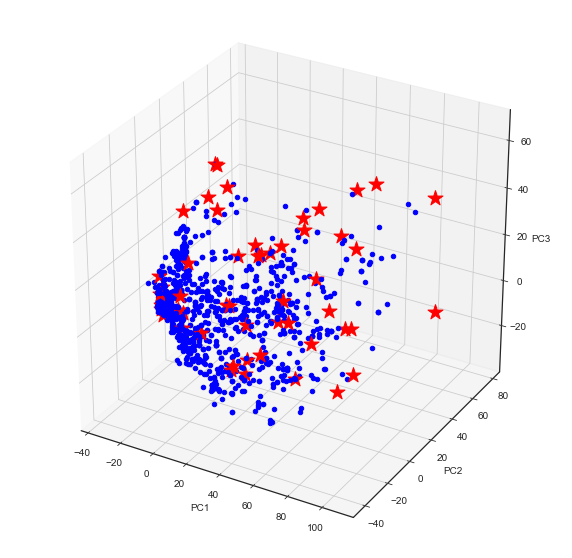

In [55]:
from mpl_toolkits.mplot3d import Axes3D

def PCA_SpaceVisualization(X,Prototypes,title='PCA visualization',withText=False):
    '''
    PCA to given array X and creating a plot
    Returns PCA components array after fit_transform
    '''
    
    # PCA code
    pca = PCA(n_components=2)
    pca.fit(X)
    pcaComponents = pca.fit_transform(X) # pcaComponents is the data that I'll use from PCA
    
    print("Explained varianse of PCA:", pca.explained_variance_ratio_)
    
    # Seperating components
    first_component = [x[0] for x in pcaComponents]
    second_component = [x[1] for x in pcaComponents]
    
    # Plotting code
    fig, ax = plt.subplots(figsize=(25,10))
#     ax.scatter(first_component, second_component,alpha=0) 
    fig.suptitle(title,fontsize=15,fontweight="bold")
    
    for x0, y0, i in zip(first_component, second_component,range(0,len(first_component),1)):
        if(withText):
            if i in Prototypes:
                plt.text(x0,y0,i, ha="center", va="center",fontsize=16,color='r',fontweight="bold")
            else:
                plt.text(x0,y0,i, ha="center", va="center",fontsize=8,color='b')
        else:
            if i in Prototypes:
                plt.scatter(x0,y0,color='r',s=250,marker='*',alpha=1.0)
            else:
                plt.scatter(x0,y0,color='b',s=80,marker='.',alpha=1.0)
    plt.show()
    return pcaComponents

def PCA_SpaceVisualization_3D(X,Prototypes,title='PCA visualization',withText=False):
    
    # PCA code
    pca = PCA(n_components=3)
    pca.fit(X)
    pcaComponents = pca.fit_transform(X) # pcaComponents is the data that I'll use from PCA
    
    # Seperating components
    first_component = [x[0] for x in pcaComponents]
    second_component = [x[1] for x in pcaComponents]
    third_component = [x[2] for x in pcaComponents]

    # Plotting code
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
#     fig, ax = plt.subplots(, projection="3D")

    print("Explained varianse of PCA:", pca.explained_variance_ratio_)

    
    for x0, y0, z0, i in zip(first_component, second_component, third_component, range(0,len(first_component),1)):
        if(withText):
            if i in Prototypes:
                plt.text(x0,y0,z0, i, ha="center", va="center",fontsize=16,color='r',fontweight="bold")
            else:
                plt.text(x0,y0,z0,i, ha="center", va="center",fontsize=8,color='b')
        else:
            if i in Prototypes:
                ax.scatter(x0,y0,z0,color='r',s=250,marker='*',alpha=1.0)
            else:
                ax.scatter(x0,y0,z0,color='b',s=80,marker='.',alpha=1.0)
                
    # label the axes
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")

    plt.show()
    
    return pcaComponents

pcaComponents = PCA_SpaceVisualization_3D(model.rankedVectors,model.prototypeArray)

### WTA buckets created

In [65]:
def WTA_PCA_SpaceVisualization(X,Prototypes,Labels,title='PCA visualization',withText=False,withgroundruth=False,groundruth=None):
    '''
    PCA to given array X and creating a plot
    Returns PCA components array after fit_transform
    '''
    
    # PCA code
    pca = PCA(n_components=2)
    pca.fit(X)
    pcaComponents = pca.fit_transform(X) # pcaComponents is the data that I'll use from PCA
    
    # Seperating components
    first_component = [x[0] for x in pcaComponents]
    second_component = [x[1] for x in pcaComponents]
    
    # Plotting code
    fig, ax = plt.subplots(figsize=(25,10))
    cm = plt.get_cmap('jet') 
    
    if not withgroundruth:
        labels = [",".join(item) for item in Labels.astype(str)]
        mydict={}
        i = 0
        for item in labels:
            if(i>0 and item in mydict):
                continue
            else:    
               i = i+1
               mydict[item] = i

        k=[]
        for item in labels:
            k.append(mydict[item])
        
    else:
        k=groundruth

    ax.scatter(first_component, second_component, c = k, cmap=cm, s=30) 
    fig.suptitle(title,fontsize=15,fontweight="bold")
    
    if not withgroundruth:
        for x0, y0, i in zip(first_component, second_component,range(0,len(first_component),1)):
            if i in set(Prototypes):
                plt.scatter(x0,y0,c='red',s=400,marker='*',alpha=0.2)
    plt.show()
    return pcaComponents

def WTA_PCA_SpaceVisualization_3D(X,Prototypes,Labels,title='PCA visualization',withText=False,withgroundruth=False,groundruth=None):
    
    # PCA code
    pca = PCA(n_components=3)
    pca.fit(X)
    pcaComponents = pca.fit_transform(X) # pcaComponents is the data that I'll use from PCA
    
    # Seperating components
    first_component = [x[0] for x in pcaComponents]
    second_component = [x[1] for x in pcaComponents]
    third_component = [x[2] for x in pcaComponents]

    # Plotting code
    fig = plt.figure(figsize=(30,20))
    ax = fig.add_subplot(111, projection='3d')
    cm = plt.get_cmap('jet') 

    
    print("Explained varianse of PCA:", pca.explained_variance_ratio_)

    if not withgroundruth:
        labels = [",".join(item) for item in Labels.astype(str)]
        mydict={}
        i = 0
        for item in labels:
            if(i>0 and item in mydict):
                continue
            else:    
               i = i+1
               mydict[item] = i

        k=[]
        for item in labels:
            k.append(mydict[item])
        
    else:
        k=groundruth

    ax.scatter(first_component, second_component, third_component, c = k, cmap=cm, s=30) 
    fig.suptitle(title,fontsize=15,fontweight="bold")
    
    if not withgroundruth:
        for x0, y0, z0, i in zip(first_component, second_component, third_component, range(0,len(first_component),1)):
            if i in set(Prototypes):
                ax.scatter(x0,y0,z0,c='red',s=400,marker='*',alpha=0.2)
                
    # label the axes
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")

    plt.show()
    
    return pcaComponents

# pcaComponents = PCA_SpaceVisualization_3D(model.rankedVectors,model.prototypeArray)

Explained varianse of PCA: [0.3172019  0.16395465 0.06953446]


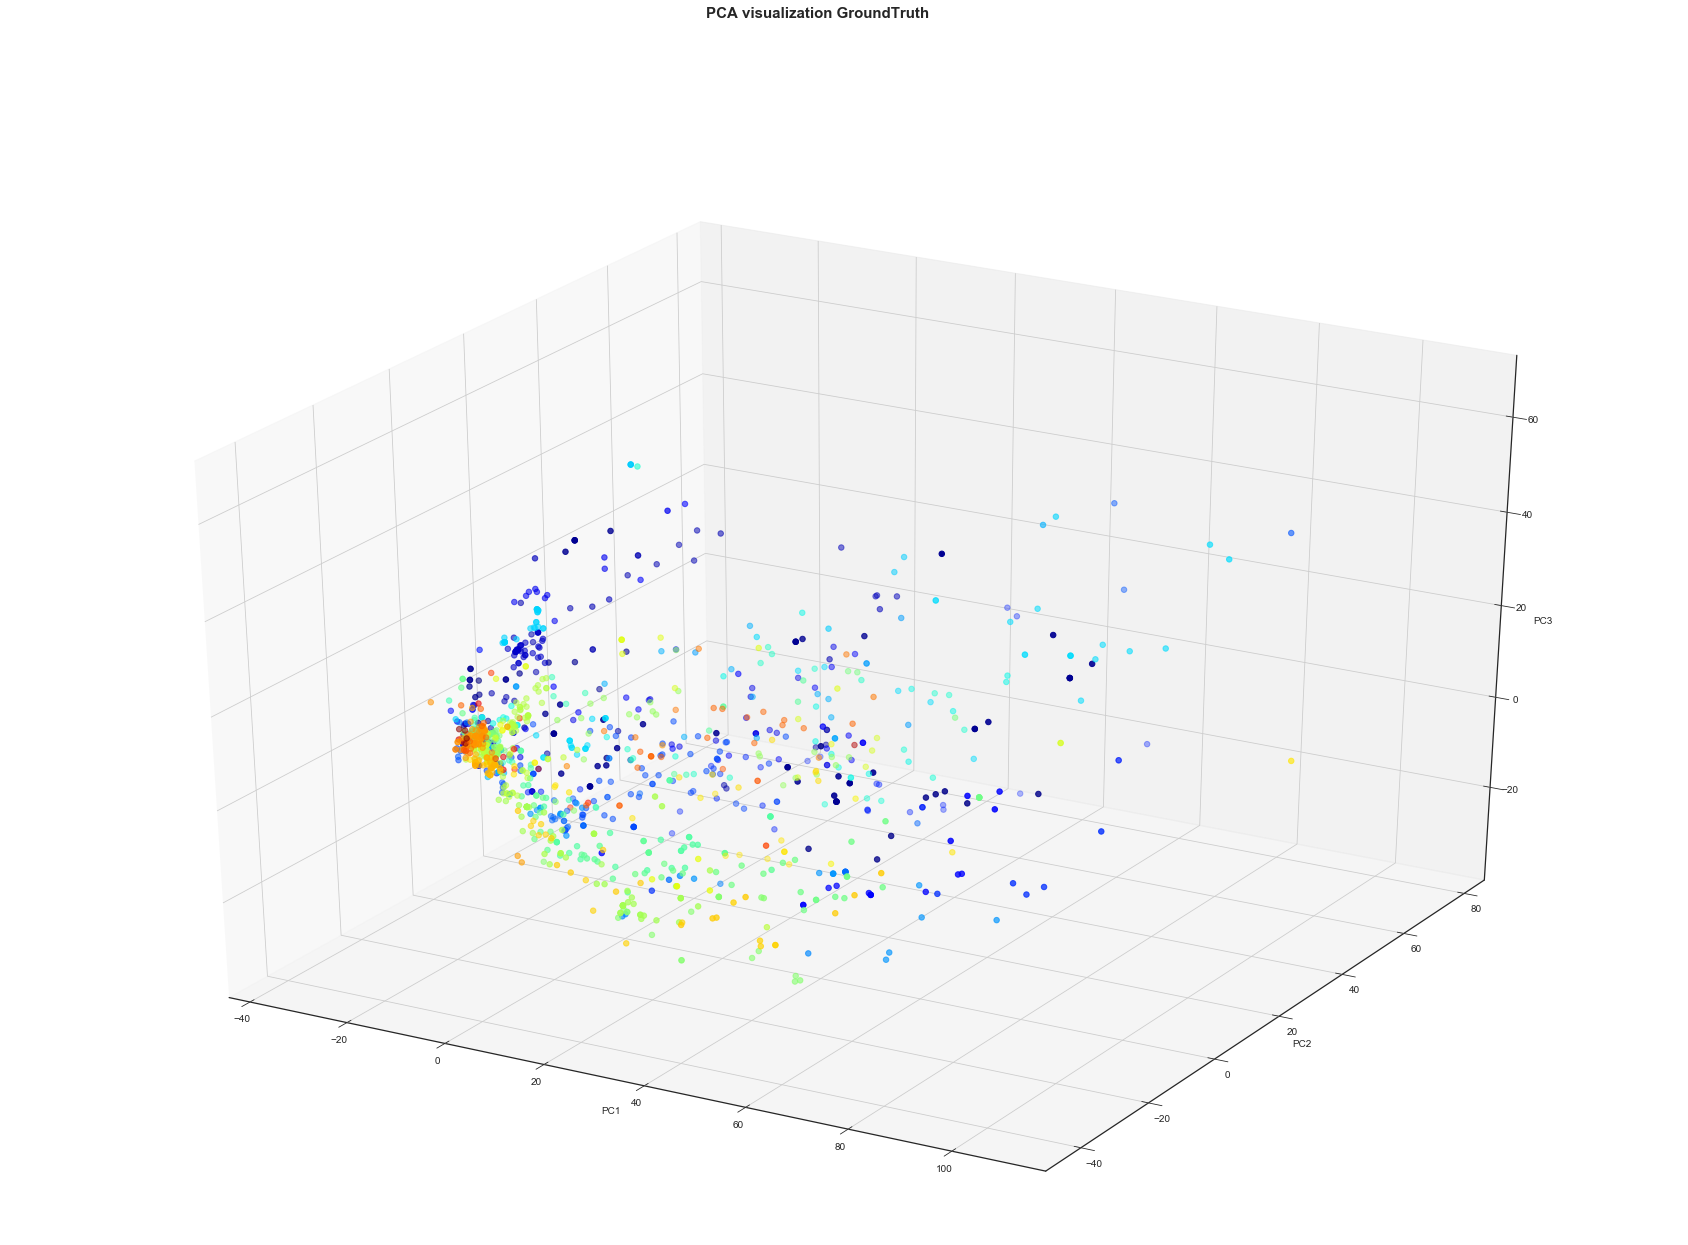

In [66]:
pcaComponents = WTA_PCA_SpaceVisualization_3D(model.rankedVectors,model.prototypeArray,model.HashedClusters,withgroundruth=True,groundruth=labels_groundTruth,title='PCA visualization GroundTruth')

### Prototype selection variance HeatMap

In [26]:
def similarityProbsHeatMapWithClusters(similarityProb_matrix,clusters,title):
    fif,ax = plt.subplots(1,figsize=(20,20))
    colors = ['red','green','blue','yellow','orange']
    c=0
    for cl in clusters:
        for i  in range(0,len(cl)):
            for j in range(i+1,len(cl)):
                ax.add_patch(Rectangle((cl[j],cl[i]), 1, 1, fill=False, edgecolor=colors[c], lw=3))
        c+=1
#     corr = np.corrcoef(ed_matrix)
#     mask = np.zeros_like(corr)
#     mask[np.tril_indices_from(mask)] = True
    ax.set_title(title,fontsize=20,fontweight='bold')
    ax = sns.heatmap(similarityProb_matrix, linewidth=0.5,annot=True,cmap="Blues",fmt='.3g',ax=ax)
    plt.show()
    
def similarityProbsHeatMap(similarityProb_matrix,title):
    fif,ax = plt.subplots(1,figsize=(20,20))
    ax.set_title(title,fontsize=20,fontweight='bold')
    ax = sns.heatmap(similarityProb_matrix, linewidth=0.5,annot=True,cmap="Blues",fmt='.3g',ax=ax)
    plt.show()
    

### Bigramms-Trigramms and jaccard_distance

In [27]:
sent = 'This is an example of bigramms and trigramms!'
print(set(nltk.ngrams(sent, n=3)))
print(set(nltk.ngrams(nltk.word_tokenize(sent), n=3)))
print(nltk.jaccard_distance(set(nltk.ngrams(sent, n=3)),set(nltk.ngrams(sent, n=3))))
print(nltk.jaccard_distance(set(nltk.ngrams(nltk.word_tokenize(sent), n=3)),set(nltk.ngrams(nltk.word_tokenize(sent), n=3))))

s1 = "m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r.   andersson  nan j appl. phys."
s2 = "m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  j appl. phys. "

jc3 = jaccard(set(nltk.ngrams(s1, n=3)),set(nltk.ngrams(s2, n=3)))
js3 = jaccard(set(nltk.ngrams(nltk.word_tokenize(s1), n=3)),set(nltk.ngrams(nltk.word_tokenize(s2), n=3)))
jc2 = jaccard(set(nltk.ngrams(s1, n=2)),set(nltk.ngrams(s2, n=2)))
js2 = jaccard(set(nltk.ngrams(nltk.word_tokenize(s1), n=2)),set(nltk.ngrams(nltk.word_tokenize(s2), n=2)))

print(jc3,js3,jc2,js2)
print(editdistance.eval(s1,s2))

{('a', 'm', 'm'), ('b', 'i', 'g'), ('r', 'i', 'g'), ('T', 'h', 'i'), ('n', 'd', ' '), ('t', 'r', 'i'), ('o', 'f', ' '), ('p', 'l', 'e'), ('m', 'p', 'l'), ('i', 's', ' '), (' ', 'o', 'f'), (' ', 'a', 'n'), ('a', 'm', 'p'), ('x', 'a', 'm'), ('g', 'r', 'a'), ('h', 'i', 's'), (' ', 'e', 'x'), ('a', 'n', 'd'), ('a', 'n', ' '), ('r', 'a', 'm'), ('d', ' ', 't'), (' ', 't', 'r'), ('f', ' ', 'b'), ('n', ' ', 'e'), (' ', 'b', 'i'), (' ', 'i', 's'), ('s', ' ', 'a'), ('e', ' ', 'o'), ('m', 'm', 's'), ('e', 'x', 'a'), ('s', ' ', 'i'), ('l', 'e', ' '), ('m', 's', ' '), ('i', 'g', 'r'), ('m', 's', '!')}
{('and', 'trigramms', '!'), ('bigramms', 'and', 'trigramms'), ('is', 'an', 'example'), ('of', 'bigramms', 'and'), ('an', 'example', 'of'), ('example', 'of', 'bigramms'), ('This', 'is', 'an')}
0.0
0.0
1.0 1.0 1.0 1.0
7


## __CORA Evaluation__

### Text Preprocess

In [28]:
def preprocess(row):

    paper_str = " ".join(row)

    # Lower letters 
    paper_str = paper_str.lower()
    
    # Remove unwanted chars 
    paper_str = paper_str.replace("\n", " ").replace("/z", " ")
    
    # Remove pancutation     
    paper_str = paper_str.translate(str.maketrans('', '', string.punctuation))
    
    return str(paper_str)

### Shuffle data

In [29]:
shuffled_df = CORA.sample(frac=1).reset_index(drop=True)
shuffled_df

,Entity Id,address,author,editor,institution,month,note,pages,publisher,title,venue,volume,year,Unnamed: 13
0,409,NaN,y. freund and r.e. schapire.,NaN,NaN,NaN,NaN,NaN,NaN,a decision-theoretic generalization of on-line...,"journal of computer and system sciences,",NaN,1997.,NaN
1,972,NaN,m. j. kearns and r. e. schapire.,NaN,NaN,NaN,NaN,"464-497,",NaN,efficient distribution-free learning of probab...,"journal of computer and system sciences,",48(3),1994.,NaN
2,837,NaN,m. kearns and m. li.,NaN,NaN,NaN,NaN,"22 , 807-837.",NaN,learning in the presence of malicious errors.,"siam journal on computing,",NaN,(1993).,NaN
3,1131,NaN,r. rivest and r. schapire.,NaN,NaN,NaN,NaN,"299-347,",NaN,inference of finite automata using homing sequ...,"information and computation,",103,1993.,NaN
4,20,NaN,"cesa-bianchi, n., freund, y., helmbold, d. p.,...",NaN,NaN,NaN,NaN,382-391).,NaN,how to use expert advice.,proceedings of the annual acm symposium on the...,NaN,(1993).,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1290,629,NaN,"kautz, h., kearns, m., and selman, b.",NaN,NaN,NaN,NaN,129-145.,NaN,horn approximations of empirical data.,"artificial intelligence 74,",NaN,1995.,NaN
1291,299,ca.,"freund, y., & schapire, r. e.",NaN,NaN,NaN,NaN,NaN,morgan kaufmann.,a decisiontheoretic generalization of on-line ...,"in proceedings ecml-95 san francisco,",NaN,(1995).,NaN
1292,111,"san mateo, ca, 1993.","harris drucker, robert e. schapire, and ptrice...",NaN,NaN,NaN,NaN,NaN,morgan kaufmann.,improving performance in neural networks using...,in proceedings of the fifth conf. on neural in...,NaN,NaN,NaN
1293,131,"santa cruz, ca,","a. ehrenfeucht, d. haussler, m. kearns, and l....",NaN,"university of california, computer research la...",jan-uary,NaN,NaN,NaN,a general lower bound on the number of example...,"technical report ucsc-crl-87-26,",NaN,1988.,NaN


### Create CORA dataset 

In [30]:
def cora_createDataset(cora_dataframe, true_values, fields, id_column, keepNone = False, preprocessEnabled=True):

    rawStr_col = []
    index_to_id_dict = {}
    sameEntities_dictionary = {}

    i=0
    for _, row in tqdm(cora_dataframe.iterrows()):
        index_to_id_dict[int(row[id_column])] = i
        rawStr = []
        for field in fields:
            if (isna(row[field]) and keepNone == True) or (keepNone == False and not isna(row[field])):
                rawStr.append(str(row[field]))
        i+=1
        if preprocessEnabled:
            rawStr_col.append(preprocess(rawStr))
        else:
            rawStr_col.append(rawStr)
            
    num_of_records = len(cora_dataframe)
    trueValues_matrix = np.zeros([num_of_records,num_of_records],dtype=np.int8)

    for _, row in tqdm(true_values.iterrows()):  
        trueValues_matrix[index_to_id_dict[row['id1']]][index_to_id_dict[row['id2']]] = 1
        trueValues_matrix[index_to_id_dict[row['id2']]][index_to_id_dict[row['id1']]] = 1

    return rawStr_col, trueValues_matrix

def isna(value):
    if isinstance(value, float) and math.isnan(value):
        return True 
    else:
        return False
    
def create_trueLabels(idColumn,groundTruth):
    data = list(zip(groundTruth.id1, groundTruth.id2))
    G = nx.Graph()
    G.add_edges_from(data)
    groups = list(nx.connected_components(G))
    newId = len(groups)
    labels_groundTruth = np.empty([len(idColumn)], dtype=int)
    for tid in idColumn:
        for g,g_index in zip(groups,range(0,len(groups),1)):
            if tid in g:
                labels_groundTruth[tid] = g_index

        if labels_groundTruth[tid] not in range(0,len(groups),1):
            labels_groundTruth[tid] = newId
            newId+=1
            
    return labels_groundTruth,newId,groups

In [31]:
fields = [
     'address',
     'author',
     'editor',
     'institution',
     'month',
     'note',
     'pages',
     'publisher',
     'title',
     'venue',
     'volume',
     'year',
     'Unnamed: 13'
]

# fields = [
#      'author',
#      'title',
# ]

data, true_matrix = cora_createDataset(CORA, CORA_groundTruth, fields, 'Entity Id')
# data, true_matrix = cora_createDataset(CORA1, CORA1_groundTruth, fields, '@id')

In [32]:
labels_groundTruth, numOfObjWithoutDups, groups = create_trueLabels(CORA['Entity Id'].tolist(),CORA_groundTruth)            
data_length = [ len(x) for x in data ]

### CORA specs

In [33]:
specs = {
    'Objects without any duplicates' : numOfObjWithoutDups-len(groups), 
    'Objects with duplicates' : sum([len(x) for x in groups]),
    'Total number of objects' : CORA.shape[0], 
    'Number of ER clusters' : len(groups),
    'Dataset size' : len(data), 
    'Average length' : np.mean(data_length), 
    'Min length' : min(data_length), 
    'Max length' : max(data_length), 
    'Median length' : np.median(data_length)
}

specsCoraDf = pd.DataFrame(list(specs.items()), columns=['Spec','#number'])
specsCoraDf[['#number']] = specsCoraDf[['#number']].astype(int)
specsCoraDf.style.hide_index()

Spec,#number
Objects without any duplicates,19
Objects with duplicates,1276
Total number of objects,1295
Number of ER clusters,93
Dataset size,1295
Average length,164
Min length,38
Max length,366
Median length,164


#### Dataset attributes

In [34]:
list(CORA.columns)

['Entity Id',
 'address',
 'author',
 'editor',
 'institution',
 'month',
 'note',
 'pages',
 'publisher',
 'title',
 'venue',
 'volume',
 'year',
 'Unnamed: 13']

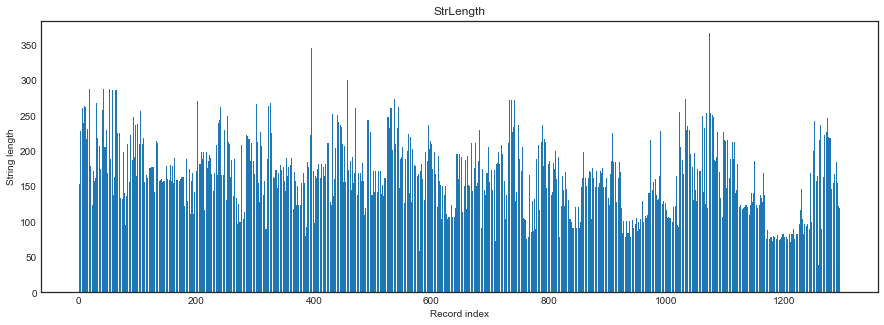

In [35]:
plt.figure(figsize=(15,5))
plt.bar(range(0,len(data_length),1),data_length)
plt.xlabel("Record index")
plt.ylabel("String length")
plt.title("StrLength")
plt.show()

Results dataframe

In [36]:
results_dataframe = pd.DataFrame(columns=['max_numberOf_clusters','max_editDistance','similarityThreshold','windowSize','metric','similarityVectors',"distanceMetricEmbedding","distanceMetric","number_of_permutations","ngramms","jaccard_with_chars",'Accuracy','Precision','Recall','F1','Time'])

### CORA: Best Jaccard execution


#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



[0, 2, 3, 4, 6, 8, 11, 14, 17, 19, 20, 21, 22, 23, 25, 29, 31, 32, 34, 35, 36, 38, 41, 45, 47, 48, 49, 50, 51, 53, 54, 56, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 70, 72, 73, 74, 76, 78, 79, 81, 82, 84, 86, 88, 90, 91, 92, 94, 96, 97, 98, 99, 101, 103, 104, 106, 108, 110, 111, 114, 115, 116, 117, 118, 121, 125, 126, 127, 128, 130, 131, 132, 134, 136, 145, 148, 150, 154, 156, 158, 160, 162, 165, 168, 172, 174, 176, 178, 180, 184, 186, 187, 189, 190, 194, 195, 196, 198, 200, 201, 202, 203, 205, 207, 208, 211, 213, 214, 216, 217, 220, 222, 225, 227, 228, 229, 231, 233, 234, 236, 238, 240, 242, 243, 245, 246, 250, 251, 253, 256, 258, 260, 261, 263, 265, 266, 267, 269, 271, 274, 276, 277, 282, 286, 290, 292, 295, 297, 298, 299, 303, 305, 307, 308, 309, 310, 313, 314, 315, 316, 317, 319, 321, 323, 326, 327, 328, 330, 332, 336, 339, 341, 343, 345, 347, 349, 351, 354, 357, 358, 359, 361, 363, 364, 366, 368, 369, 370, 371, 373, 374, 376, 378, 380, 383, 385, 386, 387, 389, 392, 395, 397, 398, 3

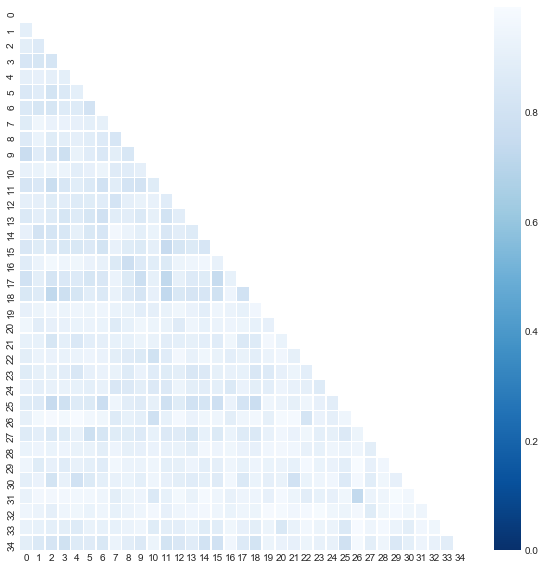


- Mean variance in prototype selection:  0.8710078302412472

- Final number of prototypes:  35

# Finished in 15.842 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[ 1. 20. 17. ... 33. 31. 18.]
 [18.  1.  8. ... 29. 24.  5.]
 [18.  1.  7. ... 30. 24.  6.]
 ...
 [ 9. 33. 27. ... 21. 20. 29.]
 [15. 32. 25. ... 34. 31. 30.]
 [15. 32. 25. ... 34. 31. 30.]]


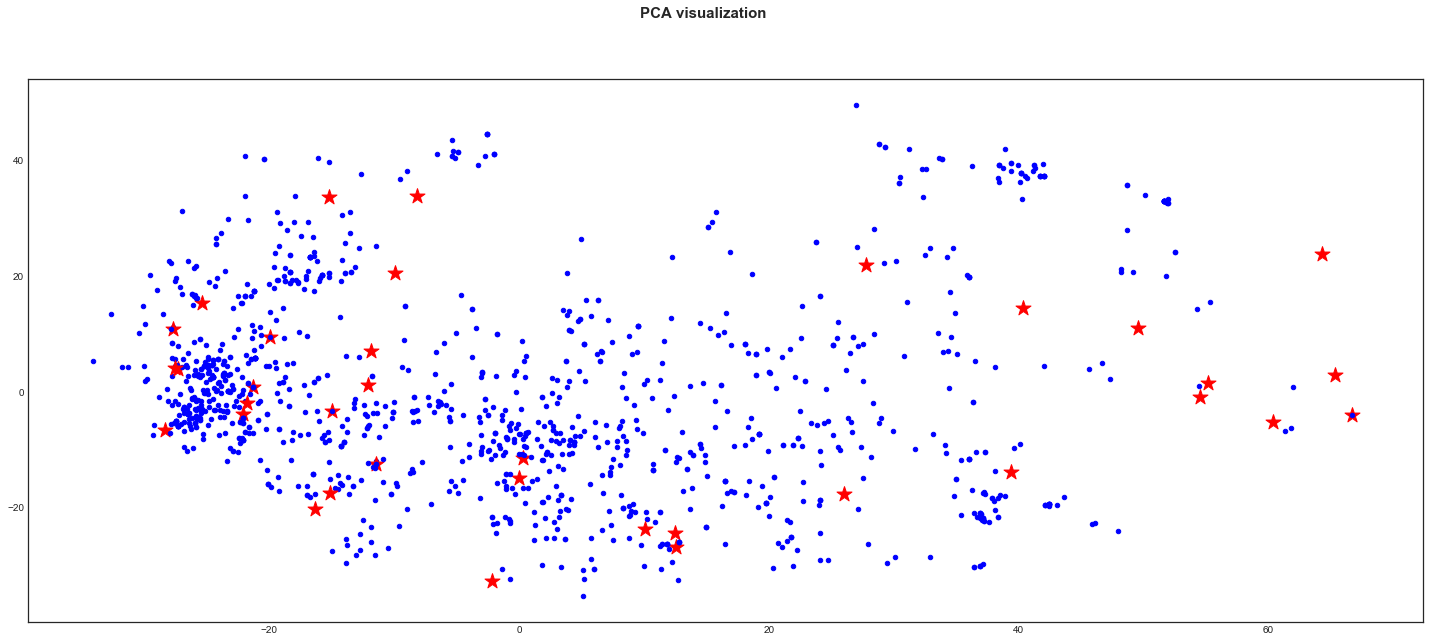


# Finished in 11.574 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[24 21]  ->  [0, 15, 16, 17, 18, 19, 21, 22, 23, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 44, 45, 46, 47, 48, 50, 51, 59, 61, 63, 64, 65, 66, 67, 68, 69, 70, 74, 77, 78, 80, 81, 93, 94, 101, 107, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 258, 371, 422, 423, 424, 425, 451, 453, 472, 473, 474, 475, 524, 536, 540, 591, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 606, 607, 608, 609, 612, 613, 614, 615, 1017, 1060, 1065, 1068, 1069, 1073, 1075, 1078, 1079, 1080, 1092, 1095, 1098, 1102, 1111, 1121, 1122, 1123, 1124, 1125, 1126, 1127, 1128, 1129, 1130, 1131, 1133, 1134, 1135, 1136, 1137, 1138, 1139, 1140, 1141, 1142, 1143, 1144, 1145, 1146, 1147, 1148, 1149, 1151, 1152, 1153, 1154, 1155, 1156, 

C:\Users\nikol\anaconda3\lib\site-packages\ipykernel_launcher.py:503: UserWarning: Window size greater than vector dimension


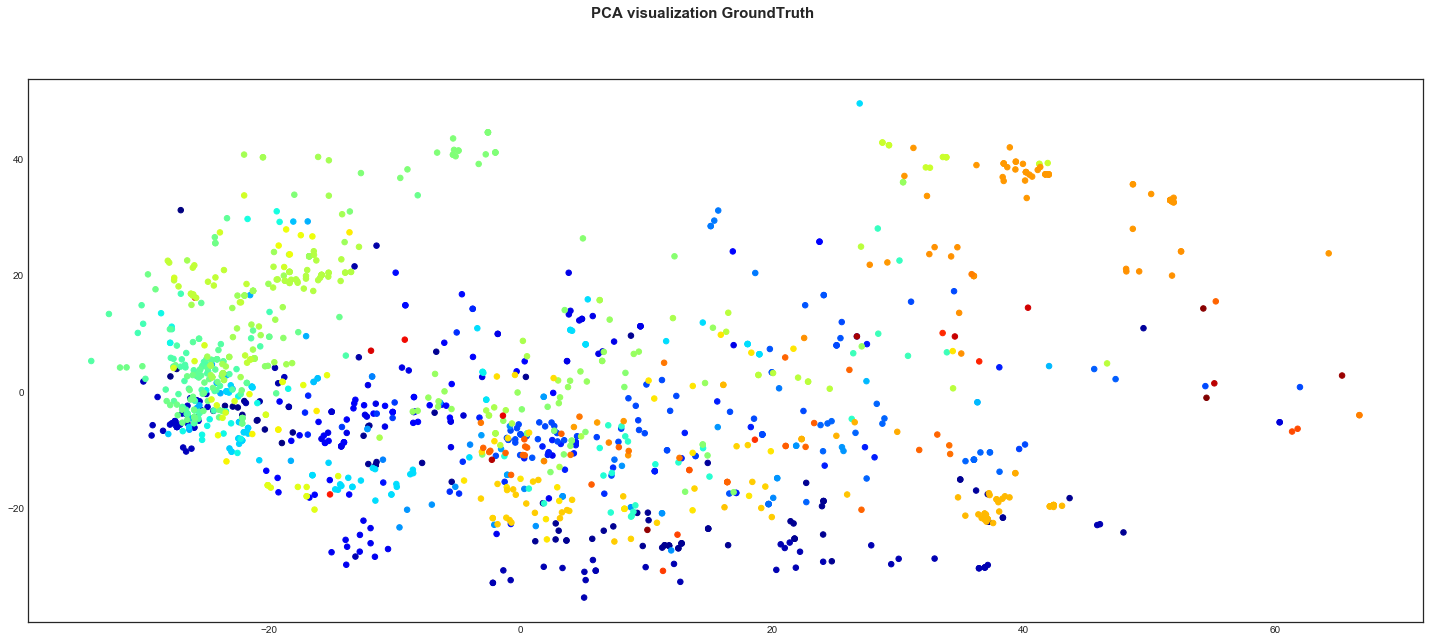


# Finished in 0.9273 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


[0, 15, 16, 17, 18, 19, 21, 22, 23, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 44, 45, 46, 47, 48, 50, 51, 59, 61, 63, 64, 65, 66, 67, 68, 69, 70, 74, 77, 78, 80, 81, 93, 94, 101, 107, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 258, 371, 422, 423, 424, 425, 451, 453, 472, 473, 474, 475, 524, 536, 540, 591, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 606, 607, 608, 609, 612, 613, 614, 615, 1017, 1060, 1065, 1068, 1069, 1073, 1075, 1078, 1079, 1080, 1092, 1095, 1098, 1102, 1111, 1121, 1122, 1123, 1124, 1125, 1126, 1127, 1128, 1129, 1130, 1131, 1133, 1134, 1135, 1136, 1137, 1138, 1139, 1140, 1141, 1142, 1143, 1144, 1145, 1146, 1147, 1148, 1149, 1151, 1152, 1153, 1154, 1155, 1156, 1157, 1158, 1249, 1251, 1252, 1253, 1254, 1257, 1258, 1265]
[1, 2, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 52, 53, 54, 55, 56, 57, 58, 60, 62, 71, 73, 83, 85, 86, 87, 88, 89, 129, 130, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 

In [37]:
%%time

ngramms= 3                                  # If jaccard used, n-gramms are used
jaccard_withchars = True                    # n-gramms either of chars and either of words

# Prototype selection
max_numberOf_clusters= 1000                  # Νumber of loops for finding representatives, it is an upper bound of clusters.
max_dissimilarityDistance= 0.4                       # The threshold for the triangle inequality
distanceMetric= 'jaccard'                   # Distance metric between the strings when creating the space
prototypesFilterThr = 0.7                   # Prototypes must differ more than that threshold

# Embedding phase
distanceMetricEmbedding = 'jaccard'  # Embedding metric

# WTA algorithm
windowSize= 70                            # Vector size for WTA algo
number_of_permutations = 2                # WTA number of permutations

# Similarity evaluation
similarityVectors='initial'                  # which vectors will be passed to WTA step
similarityThreshold= 0.6                    # Similarity threshold for the final step
metric='kendal'                             # Similarity metric between vectors

start = time.time()
model = RankedWTAHash(
    max_numberOf_clusters= max_numberOf_clusters,    
    max_dissimilarityDistance= max_dissimilarityDistance,    
    windowSize= windowSize,    
    similarityThreshold= similarityThreshold,    
    metric=metric,    
    similarityVectors=similarityVectors,    
    number_of_permutations = number_of_permutations,
    distanceMetric= distanceMetric,
    distanceMetricEmbedding = distanceMetricEmbedding,
    ngramms= ngramms,
    jaccard_withchars = jaccard_withchars,
    prototypesFilterThr = prototypesFilterThr
)
model = model.fit(data)
acc,f1,precision,recall = evaluate(model.mapping_matrix,true_matrix)
exec_time = time.time() - start
results_dataframe.loc[len(results_dataframe)+1] = [max_numberOf_clusters,max_dissimilarityDistance,similarityThreshold,windowSize,metric,similarityVectors,distanceMetricEmbedding,distanceMetric,number_of_permutations,ngramms,jaccard_withchars,acc,precision,recall,f1,exec_time]

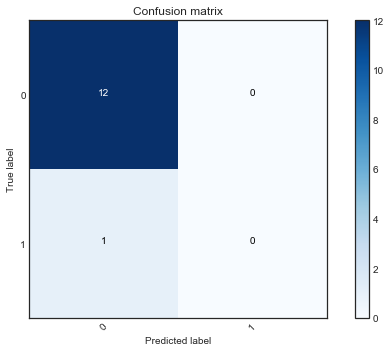

In [38]:
cm = sklearn.metrics.confusion_matrix(true_matrix.argmax(axis=1),model.mapping_matrix.argmax(axis=1),labels=[0,1])
create_ConfusionMatrix(cm,'Confusion matrix')

In [39]:
true_matrix.argmax(axis=1)

array([   0,    2,    1, ...,    0, 1294, 1293], dtype=int64)

In [40]:
model.mapping_matrix.argmax(axis=1)

array([  15,    2,    5, ...,    0, 1294,    0], dtype=int64)

### CORA: Best Edit distance execution


#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



[0, 2, 3, 4, 6, 8, 11, 14, 17, 19, 20, 21, 22, 23, 26, 29, 31, 32, 34, 36, 38, 41, 45, 47, 50, 51, 53, 54, 56, 57, 59, 60, 61, 62, 63, 64, 65, 66, 68, 70, 73, 77, 81, 85, 88, 91, 92, 94, 97, 98, 99, 101, 103, 105, 107, 109, 111, 114, 116, 119, 125, 127, 128, 130, 131, 132, 134, 136, 150, 176, 177, 178, 180, 184, 189, 194, 197, 200, 201, 202, 203, 206, 208, 211, 213, 214, 217, 220, 224, 232, 233, 235, 237, 239, 240, 242, 244, 245, 246, 250, 251, 253, 256, 258, 260, 261, 265, 267, 272, 276, 277, 282, 286, 290, 293, 296, 298, 299, 303, 305, 307, 308, 309, 310, 313, 315, 316, 319, 321, 326, 328, 332, 336, 339, 342, 345, 347, 349, 351, 353, 355, 358, 359, 364, 368, 372, 374, 376, 378, 380, 383, 385, 387, 389, 392, 395, 396, 397, 398, 399, 401, 402, 403, 409, 410, 414, 419, 424, 429, 431, 432, 434, 436, 438, 440, 441, 443, 446, 448, 449, 452, 456, 458, 460, 464, 465, 467, 469, 470, 471, 475, 481, 488, 491, 492, 493, 494, 495, 497, 503, 512, 521, 522, 523, 525, 527, 529, 532, 534, 536, 539, 

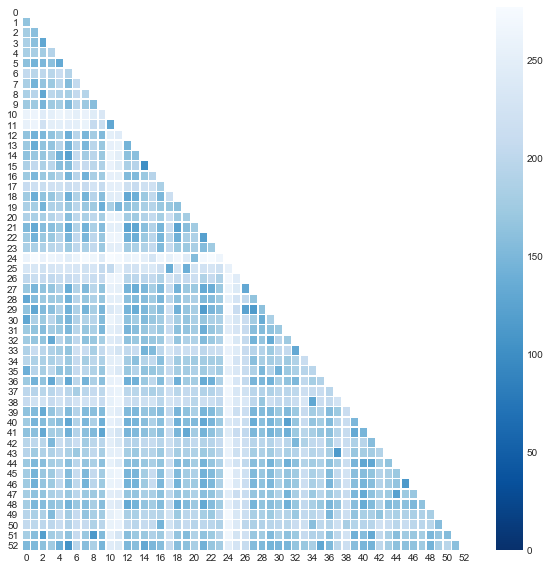


- Mean variance in prototype selection:  183.75507297970807

- Final number of prototypes:  53

# Finished in 7.3336 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[ 1.  13.  28.  ... 46.5 30.   5.5]
 [27.   1.  21.5 ... 45.  26.  15. ]
 [26.5  1.  22.  ... 43.5 21.  17.5]
 ...
 [31.5  3.  23.  ... 45.  28.  20. ]
 [34.   3.5 23.5 ... 44.  30.5 19.5]
 [34.   4.  24.5 ... 44.  29.5 20.5]]


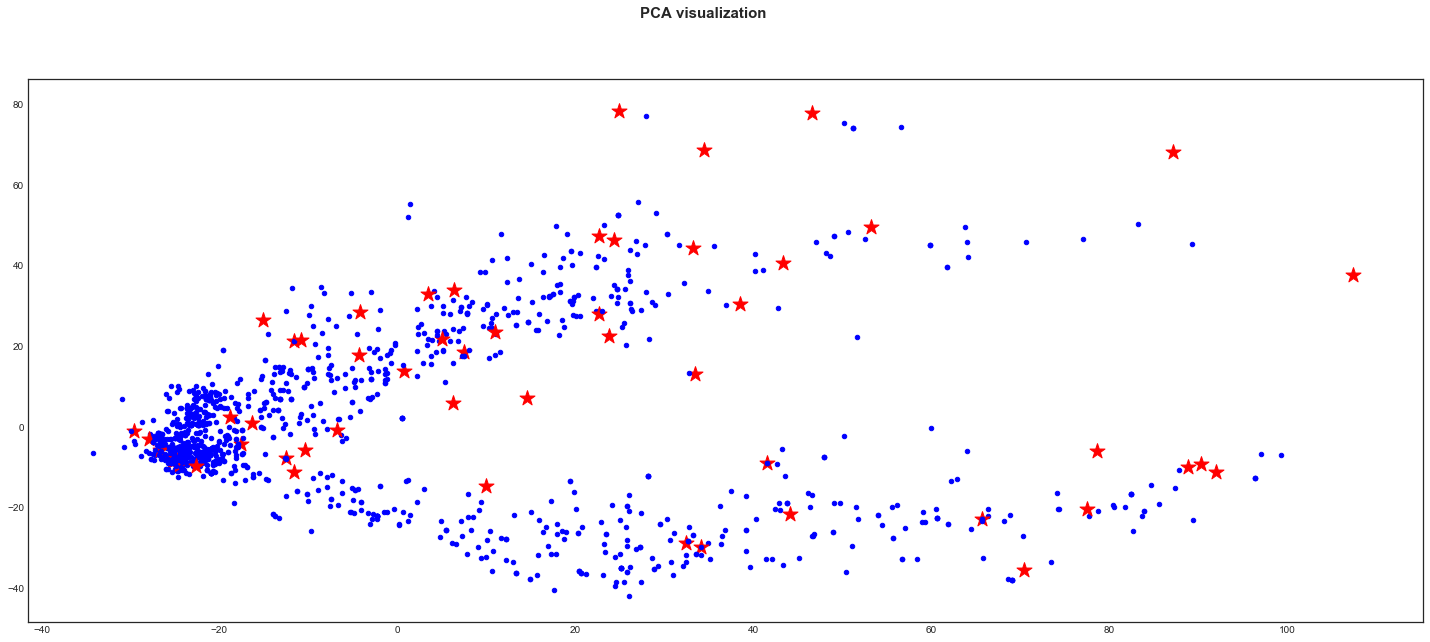


# Finished in 45.893 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[ 7 12 26]  ->  [0, 1, 2, 3, 4, 5, 7, 9, 13, 14, 16, 20, 23, 24, 25, 27, 28, 29, 36, 37, 38, 43, 46, 49, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 86, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 106, 107, 108, 109, 110, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 

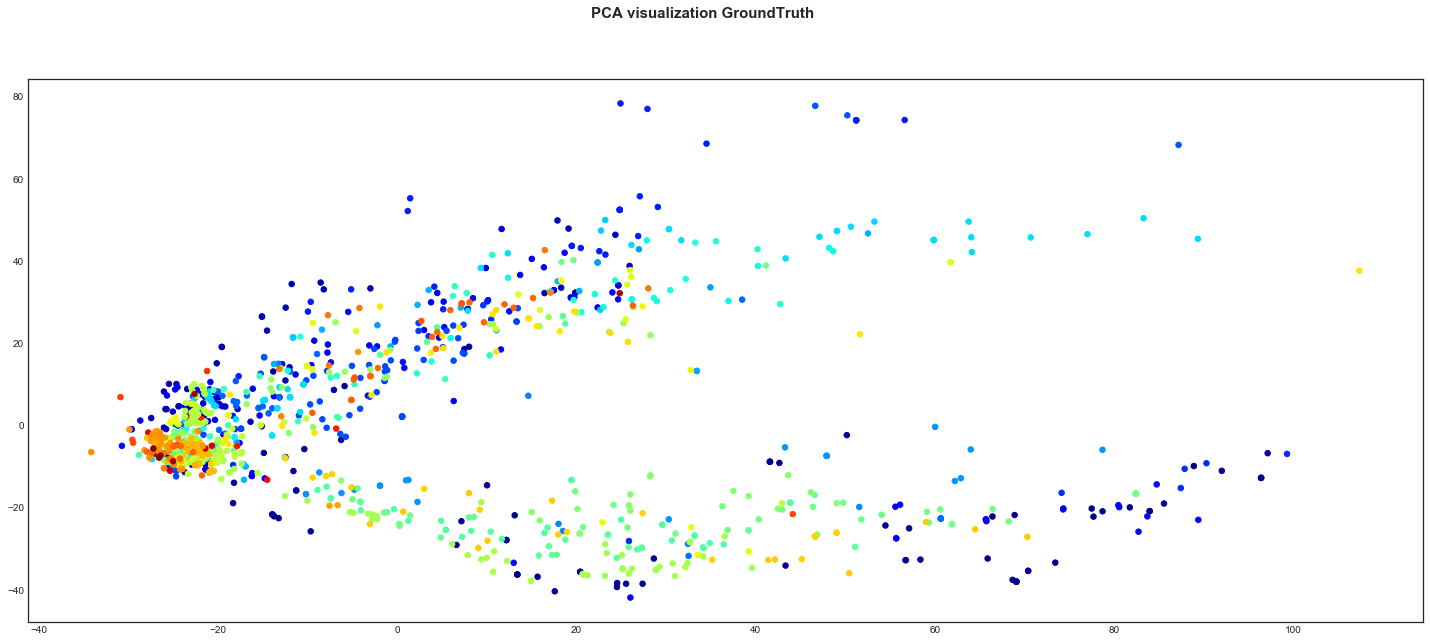


# Finished in 1.2641 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


[0, 1, 2, 3, 4, 5, 7, 9, 13, 14, 16, 20, 23, 24, 25, 27, 28, 29, 36, 37, 38, 43, 46, 49, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 86, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 106, 107, 108, 109, 110, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 242, 243, 244, 245, 246, 247, 249, 250, 251, 255

KeyboardInterrupt: 

In [41]:
%%time

# Prototype selection
max_numberOf_clusters= 1000                  # Νumber of loops for finding representatives, it is an upper bound of clusters.
max_dissimilarityDistance= 100                       # The threshold for the triangle inequality
distanceMetric= 'edit'                   # Distance metric between the vectors when creating the space
prototypesFilterThr = 100                # Prototypes must differ more that threshold

# Embedding phase
distanceMetricEmbedding = 'l_inf'  # Embedding metric

# WTA algorithm
windowSize= 37                             # Vector size for WTA algo
number_of_permutations = 3                 # WTA number of permutations


# Similarity evaluation
similarityVectors='initial'                  # which vectors will be passed to WTA step
similarityThreshold= 0.7                    # Similarity threshold for the final step
metric='kendal'                             # Similarity metric between vectors


start = time.time()
model = RankedWTAHash(
    max_numberOf_clusters= max_numberOf_clusters,    
    max_dissimilarityDistance= max_dissimilarityDistance,    
    windowSize= windowSize,    
    similarityThreshold= similarityThreshold,    
    metric=metric,    
    similarityVectors=similarityVectors,    
    number_of_permutations = number_of_permutations,
    distanceMetric= distanceMetric,
    distanceMetricEmbedding = distanceMetricEmbedding,
    ngramms= ngramms,
    jaccard_withchars = jaccard_withchars,
    prototypesFilterThr = prototypesFilterThr
)
model = model.fit(data)
acc,f1,precision,recall = evaluate(model.mapping_matrix,true_matrix, False)
exec_time = time.time() - start
results_dataframe.loc[len(results_dataframe)+1] = [max_numberOf_clusters,max_dissimilarityDistance,similarityThreshold,windowSize,metric,similarityVectors,distanceMetricEmbedding,distanceMetric,number_of_permutations,ngramms,jaccard_withchars,acc,precision,recall,f1,exec_time]

### Embeddings

In [42]:
pcaComponents = PCA_SpaceVisualization(model.Embeddings,model.prototypeArray,withText=True)

ValueError: Image size of 197511x65388 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1800x720 with 1 Axes>

In [48]:
pcaComponents = PCA_SpaceVisualization(model.rankedVectors,model.prototypeArray)

TypeError: __init__() got an unexpected keyword argument 'projection'

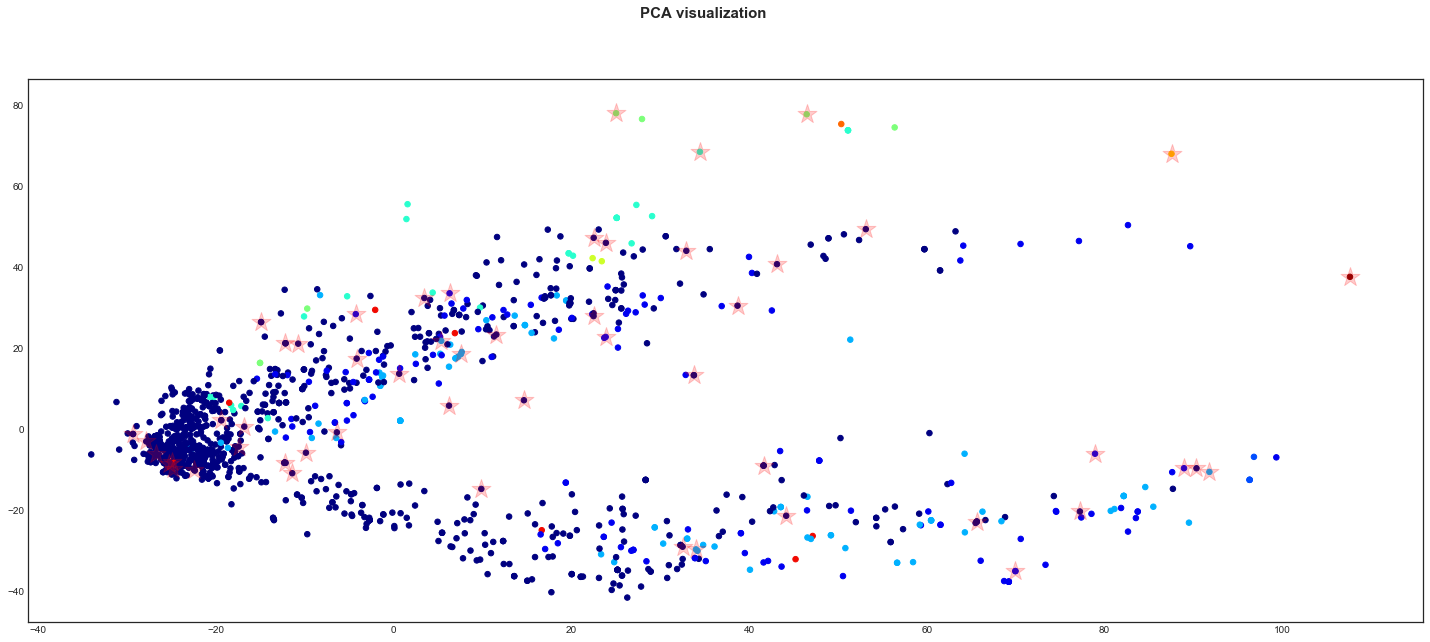

In [44]:
pcaComponents = WTA_PCA_SpaceVisualization(model.rankedVectors,model.prototypeArray,model.HashedClusters)

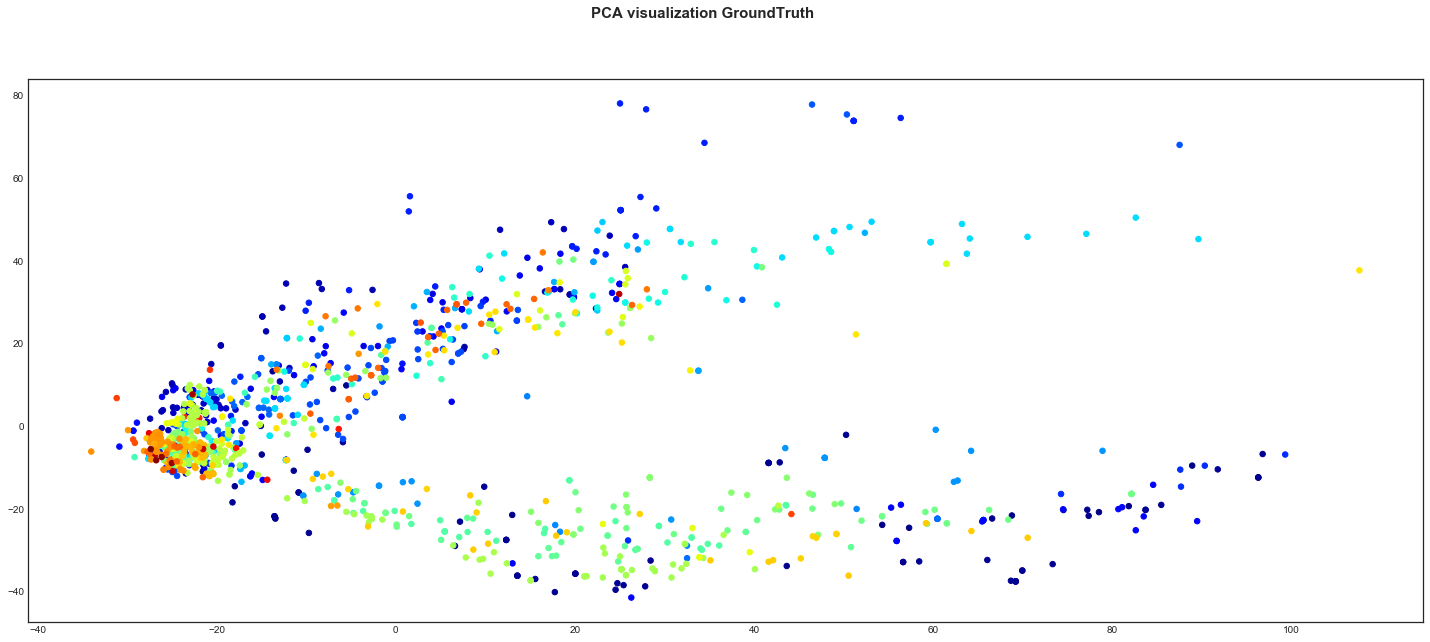

In [45]:
pcaComponents = WTA_PCA_SpaceVisualization(model.rankedVectors,model.prototypeArray,model.HashedClusters,withgroundruth=True,groundruth=labels_groundTruth,title='PCA visualization GroundTruth')

### MMD${}^2$ error between distribution of Prototypes and whole Dataset

In [46]:
myMMD2(model)

KeyboardInterrupt: 

### Grid search each section

#### GridSearch function

In [ ]:
def GridSearch_cora(data,true_matrix,max_numberOf_clusters,max_dissimilarityDistance,similarityThreshold,windowSize,metric,similarityVectors,distanceMetricEmbedding,distanceMetric,number_of_permutations,ngramms,withchars,prototypeFilter,earlyStop):
    results_dataframe = pd.DataFrame(columns=['max_numberOf_clusters','max_dissimilarityDistance','similarityThreshold','windowSize','metric','similarityVectors',"distanceMetricEmbedding","distanceMetric","number_of_permutations",'prototypesFilterThr',"protSelectionVariance",'numOfPrototypes','numOfBuckets','averageBucketSize','Accuracy','Precision','Recall','F1','Time'])
    i=1
    for n1 in tqdm(max_numberOf_clusters):
        for n2 in (max_dissimilarityDistance):
            for n3 in (similarityThreshold):
                for n4 in (windowSize):
                    for n5 in (metric):
                        for n6 in (similarityVectors):
                            for n7 in (distanceMetricEmbedding):
                                for n8 in (distanceMetric):
                                    for n9 in (number_of_permutations):
                                        for n10 in (withchars):
                                            for n11 in (withchars):
                                                for n12 in (prototypeFilter):
                                                    print("+ ------------  ",i,"   ------------- +")
                                                    print('max_numberOf_clusters: ',n1)
                                                    print('max_dissimilarityDistance: ',n2)
                                                    print('similarityThreshold: ',n3)
                                                    print('windowSize: ',n4)
                                                    print('metric: ',n5)
                                                    print('similarityVectors: ',n6)
                                                    print('distanceMetricEmbedding: ',n7)
                                                    print('distanceMetric: ',n8)
                                                    print('number_of_permutations: ',n9)
                                                    print('withchars: ',n10)
                                                    print('ngramms: ',n11)
                                                    print('prototypeFilter: ',n12)
                                                    print("+ ----------------------------------- +")
                                                    start = time.time()
                                                    model = RankedWTAHash(
                                                      earlyStop = earlyStop,
                                                      max_numberOf_clusters= n1,
                                                      max_dissimilarityDistance= n2,
                                                      windowSize= n4,
                                                      similarityThreshold= n3,
                                                      maxOnly= False,
                                                      metric=n5,
                                                      similarityVectors=n6,
                                                      number_of_permutations = n9,
                                                      distanceMetric= n8,
                                                      distanceMetricEmbedding = n7,
                                                      jaccard_withchars = n10,
                                                      ngramms= n11,                                                      
                                                      prototypesFilterThr = n12
                                                    )
                                                    model = model.fit(data)
                                                    exec_time = time.time() - start
                                                    if model.earlyStop==0:                                            
                                                        acc,f1,precision,recall = evaluate(model.mapping_matrix,true_matrix)
                                                        for key in model.buckets.keys():
                                                            tempListmodel.buckets[key]
                                                        averageBucketSize = np.mean([len(model.buckets[x]) for x in model.buckets.keys() ])
                                                        numOfBuckets=len(model.buckets.keys())
                                                    else:
                                                        if model.earlyStop == 3:
                                                            acc = f1 = precision = recall = 'Not counted'
                                                            averageBucketSize = np.mean([len(model.buckets[x]) for x in model.buckets.keys() ])
                                                            numOfBuckets=len(model.buckets.keys())
                                                        else:
                                                            numOfBuckets = averageBucketSize = acc = f1 = precision = recall = 'Not counted'
                                                    i+=1
                                                    results_dataframe.loc[len(results_dataframe)+1] = [n1,n2,n3,n4,n5,n6,n7,n8,n9,n12,model.selectionVariance,model.selected_numOfPrototypes,numOfBuckets,averageBucketSize,acc,precision,recall,f1,exec_time]
    now = datetime.now()
    current_time = now.strftime("%H_%M_%S")
    results_dataframe.to_pickle(str(current_time)+".pkl")
    
    return results_dataframe

#### __[i]__ __Prototype selection__


First of all, we need to find some ways on evaluating the prototype selection algorithm. Vantage Spaces are not something new, but we need to examine its behaviour on CORA dataset.

Goals:

- __Variance__: We want prototypes to be as much different as possible. 
- __Number__: We need a large amount of prototypes.

Ways to evaluate the algorithm:

- Mean distance between selected prototypes
- Show a HeatMap of consisted of the distances
- Some greedy search on the parameters. Parameters to fine tunne:
    -  ```max_numberOf_clusters```: Νumber of loops for finding representatives, it is an upper bound of clusters.
    -  ```max_dissimilarityDistance```:  The threshold for the triangle inequality
    -  ```distanceMetric```:  Distance metric between the vectors when creating the space
    -  ```prototypesFilterThr```: Prototypes must differ more that threshold


All these parameters will be tested both for edit distance and jaccard with 3-grams.

__Maximum mean discrepancy (MMD)__, which measures the discrepancy between two distributions. The selection of prototypes creates a density distribution of prototypes. We want to evaluate whether the prototypes distribution differs from the data distribution. We estimate both with kernel density functions. The maximum mean discrepancy measures the difference between two distributions, which is the supremum over a function space of differences between the expectations according to the two distributions. All clear? Personally, I understand these concepts much better when I see how something is calculated with data. The following formula shows how to calculate the squared MMD measure (MMD2):
    $$
    MMD^2=\frac{1}{m^2}\sum_{i,j=1}^m{}k(z_i,z_j)-\frac{2}{mn}\sum_{i,j=1}^{m,n}k(z_i,x_j)+\frac{1}{n^2}\sum_{i,j=1}^n{}k(x_i,x_j)
    $$
    
- __k__ is a kernel function that measures the similarity of two points
- __m__ is the number of prototypes 
- __n__ is the number of data points x in our original dataset. 
- The prototypes z are a selection of data points x. 

    
Each point is multidimensional, that is it can have multiple features. The goal of MMD-critic is to minimize MMD2. The closer MMD2 is to zero, the better the distribution of the prototypes fits the data. The key to bringing MMD2 down to zero is the term in the middle, which calculates the average proximity between the prototypes and all other data points (multiplied by 2). If this term adds up to the first term (the average proximity of the prototypes to each other) plus the last term (the average proximity of the data points to each other), then the prototypes explain the data perfectly.  

In [ ]:
def myMMD2(model):    
    mmdOnPrototypes = MMD2(model.dissimilarityDistance, model.S_index, model.prototypeArray)
    print("MMD2: ",mmdOnPrototypes)        
        
        
def MMD2(k, x, z):
    
    if type(x) is np.ndarray and type(z) is np.ndarray:
        m = z.size
        n = x.size
    else:
        m = len(z)
        n = len(x)
        
    firstSum = 0.0
    for i in range(0,m,1):
        for j in range(0,m,1):
            firstSum += k(z[i],z[j])
    
    secondSum = 0.0
    for i in range(0,m,1):
        for j in range(0,n,1):
            secondSum += k(z[i],x[j])
        
    thirdSum = 0.0
    for i in range(0,n,1):
        for j in range(0,n,1):
            thirdSum += k(x[i],x[j])
    
    mmd2 = (1/pow(m,2))*firstSum - (2/(m*n))*secondSum + (1/pow(n,2))*thirdSum
    
    
    return mmd2

In [ ]:
max_numberOf_clusters= [5000]
max_dissimilarityDistance= [20]
prototypesFilterThr = [80]

distanceMetric= ['edit']

# ---------------- #

ngramms= [3]  
jaccard_withchars = [False] 

distanceMetricEmbedding = ['euclidean']

windowSize= [50]
number_of_permutations = [5]

similarityThreshold= [0.7]
similarityVectors= ['ranked']
metric= ['kendal']

results_section1_edit = GridSearch_cora(
    data,true_matrix,
    max_numberOf_clusters,
    max_dissimilarityDistance,
    similarityThreshold,
    windowSize,
    metric,
    similarityVectors,
    distanceMetricEmbedding,
    distanceMetric,
    number_of_permutations,
    ngramms,
    jaccard_withchars,
    prototypesFilterThr,
    earlyStop=1
)

In [ ]:
max_numberOf_clusters= [100,500,1000]
max_dissimilarityDistance= [0.7,0.8]
prototypesFilterThr = [0.2,0.3]

distanceMetric= ['jaccard']


ngramms= [2,3]  
jaccard_withchars = [True] 

# ---------------- #

distanceMetricEmbedding = ['euclidean']

windowSize= [50]
number_of_permutations = [5]

similarityThreshold= [0.7]
similarityVectors= ['ranked']
metric= ['kendal']


results_section1_jac = GridSearch_cora(
    data,true_matrix,
    max_numberOf_clusters,
    max_dissimilarityDistance,
    similarityThreshold,
    windowSize,
    metric,
    similarityVectors,
    distanceMetricEmbedding,
    distanceMetric,
    number_of_permutations,
    ngramms,
    jaccard_withchars,
    prototypesFilterThr,
    earlyStop=1
)

##### Remarks

Two main factors:

- __numOfPrototypes__ and
- __protSelectionVariance__

The first one is the number of prototypes selected, which is very important as more prototypes will enhance model when creating the embeddings.

The second one is the average distance between all the prototypes selected. As this factor increases, the prototypes selected differ the most.


According to the above, best parameters so far:

- __Edit distance__


- __Jaccard with 3-grams__



#### __[ii]__ Fine tunning  __Embedding phase__

Ways to evaluate the __Embedding phase__:

- Use a PCA after embeddings made and check selected prototypes 

In [ ]:
max_numberOf_clusters= [5000]
max_dissimilarityDistance= [20,50]
prototypesFilterThr = [80]

distanceMetric= ['edit']

# ---------------- #

ngramms= [3]  
jaccard_withchars = [False] 

distanceMetricEmbedding = ['euclidean','l_inf','edit']

windowSize= [50]
number_of_permutations = [5]

similarityThreshold= [0.7]
similarityVectors= ['ranked']
metric= ['kendal']

results_section1_edit = GridSearch_cora(
    data,true_matrix,
    max_numberOf_clusters,
    max_dissimilarityDistance,
    similarityThreshold,
    windowSize,
    metric,
    similarityVectors,
    distanceMetricEmbedding,
    distanceMetric,
    number_of_permutations,
    ngramms,
    jaccard_withchars,
    prototypesFilterThr,
    earlyStop=1
)

In [ ]:
max_numberOf_clusters= [100,500,1000]
max_dissimilarityDistance= [0.7,0.8]
prototypesFilterThr = [0.2,0.3]

distanceMetric= ['jaccard']


ngramms= [2,3]  
jaccard_withchars = [True] 

# ---------------- #

distanceMetricEmbedding = ['euclidean']

windowSize= [50]
number_of_permutations = [5]

similarityThreshold= [0.7]
similarityVectors= ['ranked']
metric= ['kendal']


results_section1_jac = GridSearch_cora(
    data,true_matrix,
    max_numberOf_clusters,
    max_dissimilarityDistance,
    similarityThreshold,
    windowSize,
    metric,
    similarityVectors,
    distanceMetricEmbedding,
    distanceMetric,
    number_of_permutations,
    ngramms,
    jaccard_withchars,
    prototypesFilterThr,
    earlyStop=1
)

#### [iii] Fine tunning  __WTA algorithm__


Goals:

- __Ranked vectors dimension__
- __Permutations__: A number of permutations will be forced in order to better split data into buckets.

 
Parameters to fine tunne:

- ```windowSize```: Vector size after WTA
- ```number_of_permutations```: How many times vectors will be permuted and hashed

All these parameters will be tested both for edit distance and jaccard with 3-grams.

#### [iv] Fine tunning  __Similarity checking__

##### Various similarity metrics to check
These functions are for the similarity checking phase.

##### Spearman footrule distance

In [ ]:
def spearman_footrule_distance(s,t):
    """
    Computes the Spearman footrule distance between two full lists of ranks:
        F(s,t) = sum[ |s(i) - t(i)| ]/S,
    the normalized sum over all elements in a set of the absolute difference between
    the rank according to s and t.  As defined, 0 <= F(s,t) <= 1.
    S is a normalizer which is equal to 0.5*len(s)^2 for even length ranklists and
    0.5*(len(s)^2 - 1) for odd length ranklists.
    If s,t are *not* full, this function should not be used. s,t should be array-like
    (lists are OK).
    """
    # check that size of intersection = size of s,t?
    assert len(s) == len(t)
    sdist = sum(abs(s - t))
    # c will be 1 for odd length lists and 0 for even ones
    c = len(s) % 2
    normalizer = 0.5*(len(s)**2 - c)
    
    return sdist/normalizer

##### Ravi Kumar generalized Kendall Tau

In [ ]:
def kendall_top_k(a,b,k=None,p=0): #zero is equal 1 is max distance, compare with 1-scipy.stats.kendalltau(a,b)/2+1/2
    """
    kendall_top_k(np.array,np.array,k,p)
    This function generalise kendall-tau as defined in [1] Fagin, Ronald, Ravi Kumar, and D. Sivakumar. "Comparing top k lists." SIAM Journal on Discrete Mathematics 17.1 (2003): 134-160.
    It returns a distance: 0 for identical (in the sense of top-k) lists and 1 if completely different.
    Example:
        Simply call it with two same-length arrays of ratings (or also rankings), length of the top elements k (default is the maximum length possible), and p (default is 0, see [1]) as parameters:
            $ a = np.array([1,2,3,4,5])
            $ b = np.array([5,4,3,2,1])
            $ kendall_top_k(a,b,k=4)
    """

    if k is None:
        k = a.size
    if a.size != b.size:
        raise NameError('The two arrays need to have same lengths')
    k = min(k,a.size)
    a_top_k = np.argpartition(a,-k)[-k:]
    b_top_k = np.argpartition(b,-k)[-k:]
    common_items = np.intersect1d(a_top_k,b_top_k)
    only_in_a = np.setdiff1d(a_top_k, common_items)
    only_in_b = np.setdiff1d(b_top_k, common_items)
    kendall = (1 - (stats.kendalltau(a[common_items], b[common_items])[0]/2+0.5)) * (common_items.size**2) #case 1
    if np.isnan(kendall): # degenerate case with only one item (not defined by Kendall)
        kendall = 0
    for i in common_items: #case 2
        for j in only_in_a:
            if a[i] < a[j]:
                kendall += 1
        for j in only_in_b:
            if b[i] < b[j]:
                kendall += 1
    kendall += 2*p * special.binom(k-common_items.size,2)     #case 4
    kendall /= ((only_in_a.size + only_in_b.size + common_items.size)**2 ) #normalization
    return kendall

##### Rank Biased Overlap (RBO) 
Article: https://towardsdatascience.com/rbo-v-s-kendall-tau-to-compare-ranked-lists-of-items-8776c5182899

In [ ]:
def rbo(list1, list2, p=0.9):
   # tail recursive helper function
   def helper(ret, i, d):
       l1 = set(list1[:i]) if i < len(list1) else set(list1)
       l2 = set(list2[:i]) if i < len(list2) else set(list2)
       a_d = len(l1.intersection(l2))/i
       term = math.pow(p, i) * a_d
       if d == i:
           return ret + term
       return helper(ret + term, i + 1, d)
   k = max(len(list1), len(list2))
   x_k = len(set(list1).intersection(set(list2)))
   summation = helper(0, 1, k)
   return ((float(x_k)/k) * math.pow(p, k)) + ((1-p)/p * summation)

# Example usage
print(rbo([4,10,20], [1,2,3]))

p = 0.9
d = 3

def sum_series(p, d):
   # tail recursive helper function
   def helper(ret, p, d, i):
       term = math.pow(p, i)/i
       if d == i:
           return ret + term
       return helper(ret + term, p, d, i+1)
   return helper(0, p, d, 1)

wrbo1_d = 1 - math.pow(p, d-1) + (((1-p)/p) * d *(np.log(1/(1-p)) - sum_series(p, d-1)))

print(wrbo1_d) 

##### Winner Takes All proposed 

In [ ]:
def WTA_similarity(vector1,vector2):
    
    PO=0
    for i in range(0,len(vector1),1):
        for j in range(0,i,1):
            ij_1 = vector1[i] - vector1[j]
            ij_2 = vector2[i] - vector2[j]
            PO += WTA_Threshold(ij_1*ij_2)
    return PO

def WTA_Threshold(x):    
    if x>0:
        return 1
    else:
        return 0

In [ ]:
model.similarityProb_matrix

In [ ]:
model.mapping_matrix

In [ ]:
true_matrix

#### [v] Model final fine tunning


There are four ways to check if the predictions are right or wrong:
- __TN__ / True Negative: the case was negative and predicted negative
- __TP__ / True Positive: the case was positive and predicted positive
- __FN__ / False Negative: the case was positive but predicted negative
- __FP__ / False Positive: the case was negative but predicted positive

__Precision — What percent of your predictions were correct?__


Precision is the ability of a classifier not to label an instance positive that is actually negative. For each class, it is defined as the ratio of true positives to the sum of a true positive and false positive.
Precision:- Accuracy of positive predictions.
Precision = TP/(TP + FP)


__Recall — What percent of the positive cases did you catch?__


Recall is the ability of a classifier to find all positive instances. For each class it is defined as the ratio of true positives to the sum of true positives and false negatives.
Recall:- Fraction of positives that were correctly identified.
Recall = TP/(TP+FN)

__F1 score — What percent of positive predictions were correct?__


The F1 score is a weighted harmonic mean of precision and recall such that the best score is 1.0 and the worst is 0.0. F1 scores are lower than accuracy measures as they embed precision and recall into their computation. As a rule of thumb, the weighted average of F1 should be used to compare classifier models, not global accuracy.
F1 Score = 2*(Recall * Precision) / (Recall + Precision)

__Support__


Support is the number of actual occurrences of the class in the specified dataset. Imbalanced support in the training data may indicate structural weaknesses in the reported scores of the classifier and could indicate the need for stratified sampling or rebalancing. Support doesn’t change between models but instead diagnoses the evaluation process.

##### Edit distance

In [ ]:
max_numberOf_clusters= [100,500,1000]
max_dissimilarityDistance= [50,100]
prototypesFilterThr = [20,40,70]

distanceMetric= ['edit']

ngramms= [3]  
jaccard_withchars = [False] 

distanceMetricEmbedding = ['l_inf','euclidean']

windowSize= [16,32,64,128]
number_of_permutations = [1,4,8]

similarityThreshold= [0.7,0.75,0.8]
similarityVectors= ['initial','ranked']
metric= ['kendal','customKendal']



results_section1_edit = GridSearch_cora(
    data,true_matrix,
    max_numberOf_clusters,
    max_dissimilarityDistance,
    similarityThreshold,
    windowSize,
    metric,
    similarityVectors,
    distanceMetricEmbedding,
    distanceMetric,
    number_of_permutations,
    ngramms,
    jaccard_withchars,
    prototypesFilterThr,
    earlyStop=0
)

# References

1.   [The dissimilarity representation for pattern recognition, a tutorial
Robert P.W. Duin and Elzbieta Pekalska Delft University of Technology, The Netherlands School of Computer Science, University of Manchester, United Kingdom](http://homepage.tudelft.nl/a9p19/presentations/DisRep_Tutorial_doc.pdf)